# Importing Modules and Loading Data

We used Python 3.10.6 for this notebook, and the dependencies are the requirements.txt file in the root directory of the project.

In [1]:
from helper_functions import *
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
import pickle
from matplotlib.lines import Line2D
from matplotlib.ticker import PercentFormatter
import scipy.stats as stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
import pandas as pd
from sklearn import datasets
import os
from tqdm import tqdm
from scipy.stats import kstest, norm
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from IPython.core.interactiveshell import InteractiveShell
%matplotlib inline


In [2]:
# InteractiveShell.ast_node_interactivity = "all"
InteractiveShell.ast_node_interactivity = "none"

In [3]:
files = os.listdir('../data/0_raw')
files.remove('README.md')
files.sort()

vars = \
    ['Airlines',
    'Airports',
    'Flight_Delay_2016_2021',
    'Metadata_Flight_Delay_2016_2021',
    'US_Airlines_StockPrice_2016_2021']

urls = \
    [
        'https://www.dropbox.com/s/80pwr6adlgc0s0l/1b.%20Airlines.csv?dl=1',
        'https://www.dropbox.com/s/ra0ebqte73xr9t5/1a.%20Airports.csv?dl=1',
        'https://www.dropbox.com/s/laui1oagnaatzrh/4.%20Flight_Delay_2016_2021.csv?dl=1',
        'https://www.dropbox.com/s/10sqlmn93lm79b3/4a.%20Metadata_Flight_Delay_2016_2021.csv?dl=1',
        'https://www.dropbox.com/s/zl54ufk4frrvka9/2.%20US_Airlines_StockPrice_2016_2021.csv?dl=1'
    ]

# read in the dfs and assign to the correct variable in vars
if len(files) == 5:
    print('files found. reading in...')
    for i in tqdm(range(len(vars))):
        exec(f"{vars[i]} = pd.read_csv(f'../data/0_raw/{files[i]}')")
else:
    print('files not found. downloading...')
    print('mind that there is an input needed to continue...')
    # user MUST specify if they want to save the files locally
    save = input('save to ../data/0_raw? (y/n) ')
    for i in tqdm(range(len(vars))):
        exec(f"{vars[i]} = pd.read_csv('{urls[i]}')")  
        if save == 'y':
            exec(f"{vars[i]}.to_csv(f'../data/0_raw/{vars[i]}.csv', index=False)")


files found. reading in...


100%|██████████| 5/5 [00:00<00:00, 39.19it/s]


# Getting Basic Information About the Data

### 1a. Looking at US_Airlines_StockPrice_2016_2021

In [4]:
# to avoid displaying in scientific notation
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [5]:
s = US_Airlines_StockPrice_2016_2021.copy()

In [6]:
# s is an alias for US_Airlines_StockPrice_2016_2021
# get info about s
s.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9060 entries, 0 to 9059
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Airline    9060 non-null   object 
 1   Date       9060 non-null   object 
 2   Open       9060 non-null   float64
 3   High       9060 non-null   float64
 4   Low        9060 non-null   float64
 5   Close      9060 non-null   float64
 6   Adj Close  9060 non-null   float64
 7   Volume     9060 non-null   int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 566.4+ KB


In [7]:
# show a sample of s
display(s.sample(n=5))


Airline        Date  Open  High   Low  Close  Adj Close    Volume
6513    SAVE  11/16/2017 37.50 37.78 36.95  37.16      36.97   1340200
1294     AAL   2/24/2021 20.87 22.12 20.75  21.82      21.82  74610200
1616     DAL    6/6/2016 41.54 41.60 41.00  41.28      37.76  11538400
8329    JBLU    2/7/2019 18.05 18.22 17.97  18.10      18.10   2989300
3154     UAL   7/15/2016 47.51 47.76 46.92  47.43      47.43   5184800

In [8]:
# show the descriptive statistics of s
display(s.describe().drop(index='count'))


Open  High   Low  Close  Adj Close       Volume
mean 41.53 42.13 40.90  41.50      40.87  10464443.44
std  18.49 18.63 18.35  18.49      18.28  17230340.53
min   7.55  7.69  6.61   6.86       6.86    208900.00
25%  24.42 24.94 23.73  24.24      24.19   3584000.00
50%  42.44 43.15 41.78  42.45      41.54   5863300.00
75%  53.21 53.87 52.53  53.13      51.92   9821100.00
max  97.67 97.85 95.96  96.70      96.70 428617100.00

In [9]:
# show the unique values of the Airline column
display(s.Airline.unique())


array(['AAL', 'DAL', 'UAL', 'LUV', 'SAVE', 'JBLU'], dtype=object)

In [10]:
# dict of stock tickers to airline names
tickers_to_airline = {'AAL': 'American Airlines Inc.',
                      'DAL': 'Delta Air Lines Inc.',
                      'UAL': 'United Air Lines Inc.',
                      'LUV': 'Southwest Airlines Co.',
                      'SAVE': 'Spirit Air Lines',
                      'JBLU': 'JetBlue Airways'}
# get inverse of tickers
airlines_to_tickers = {v: k for k, v in tickers_to_airline.items()}

# add airline name column (this will be used for merging later)
s['carrier_name'] = s.Airline.map(tickers_to_airline)
# check to see if it worked
display(s.head())


Airline      Date  Open  High   Low  Close  Adj Close    Volume  \
0     AAL  1/4/2016 41.29 41.35 40.30  40.91      39.10  12037200   
1     AAL  1/5/2016 41.18 41.49 39.95  40.52      38.72  10514200   
2     AAL  1/6/2016 40.05 41.70 40.00  41.23      39.40  12393800   
3     AAL  1/7/2016 40.97 41.52 39.68  40.45      38.66  11312900   
4     AAL  1/8/2016 40.94 41.36 40.26  40.37      38.58   8853100   

             carrier_name  
0  American Airlines Inc.  
1  American Airlines Inc.  
2  American Airlines Inc.  
3  American Airlines Inc.  
4  American Airlines Inc.

The stock data covers the time period 2016 to 2021, and this table has 9060 entries and 8 columns. There are no null values.

We are most interested in the ‘Airline’, ‘Date’, and ‘Adj Close’ columns. The 'Airline' column is the stock ticker abbreviation for a particular airline. The 'Date' column is a date that an airline stock was publicly traded. The 'Adj Close' column is the adjusted closing valuation of a stock after considering things like stock splits, dividends, etc. This contrasts with the 'Close' column, which is just the price of the stock at the end of the day. 

We can use this information to calculate a daily return for the different airlines.

The airline data uses stock tickers to identify airlines. Stock tickers are not included in any other table, but there are only a 6 airlines total, so we can manually create a dictionary to match the 'Airline' ticker values in the stock table to 'carrier_name' values in the flight delay table. We can then add this field to the data to merge with later on.

### 1b. Visualizing US_Airlines_StockPrice_2016_2021

In [11]:
# InteractiveShell.ast_node_interactivity = "all"
InteractiveShell.ast_node_interactivity = "none"

In [14]:
# to avoid displaying in scientific notation
pd.set_option('display.float_format', lambda x: '%.8f' % x)

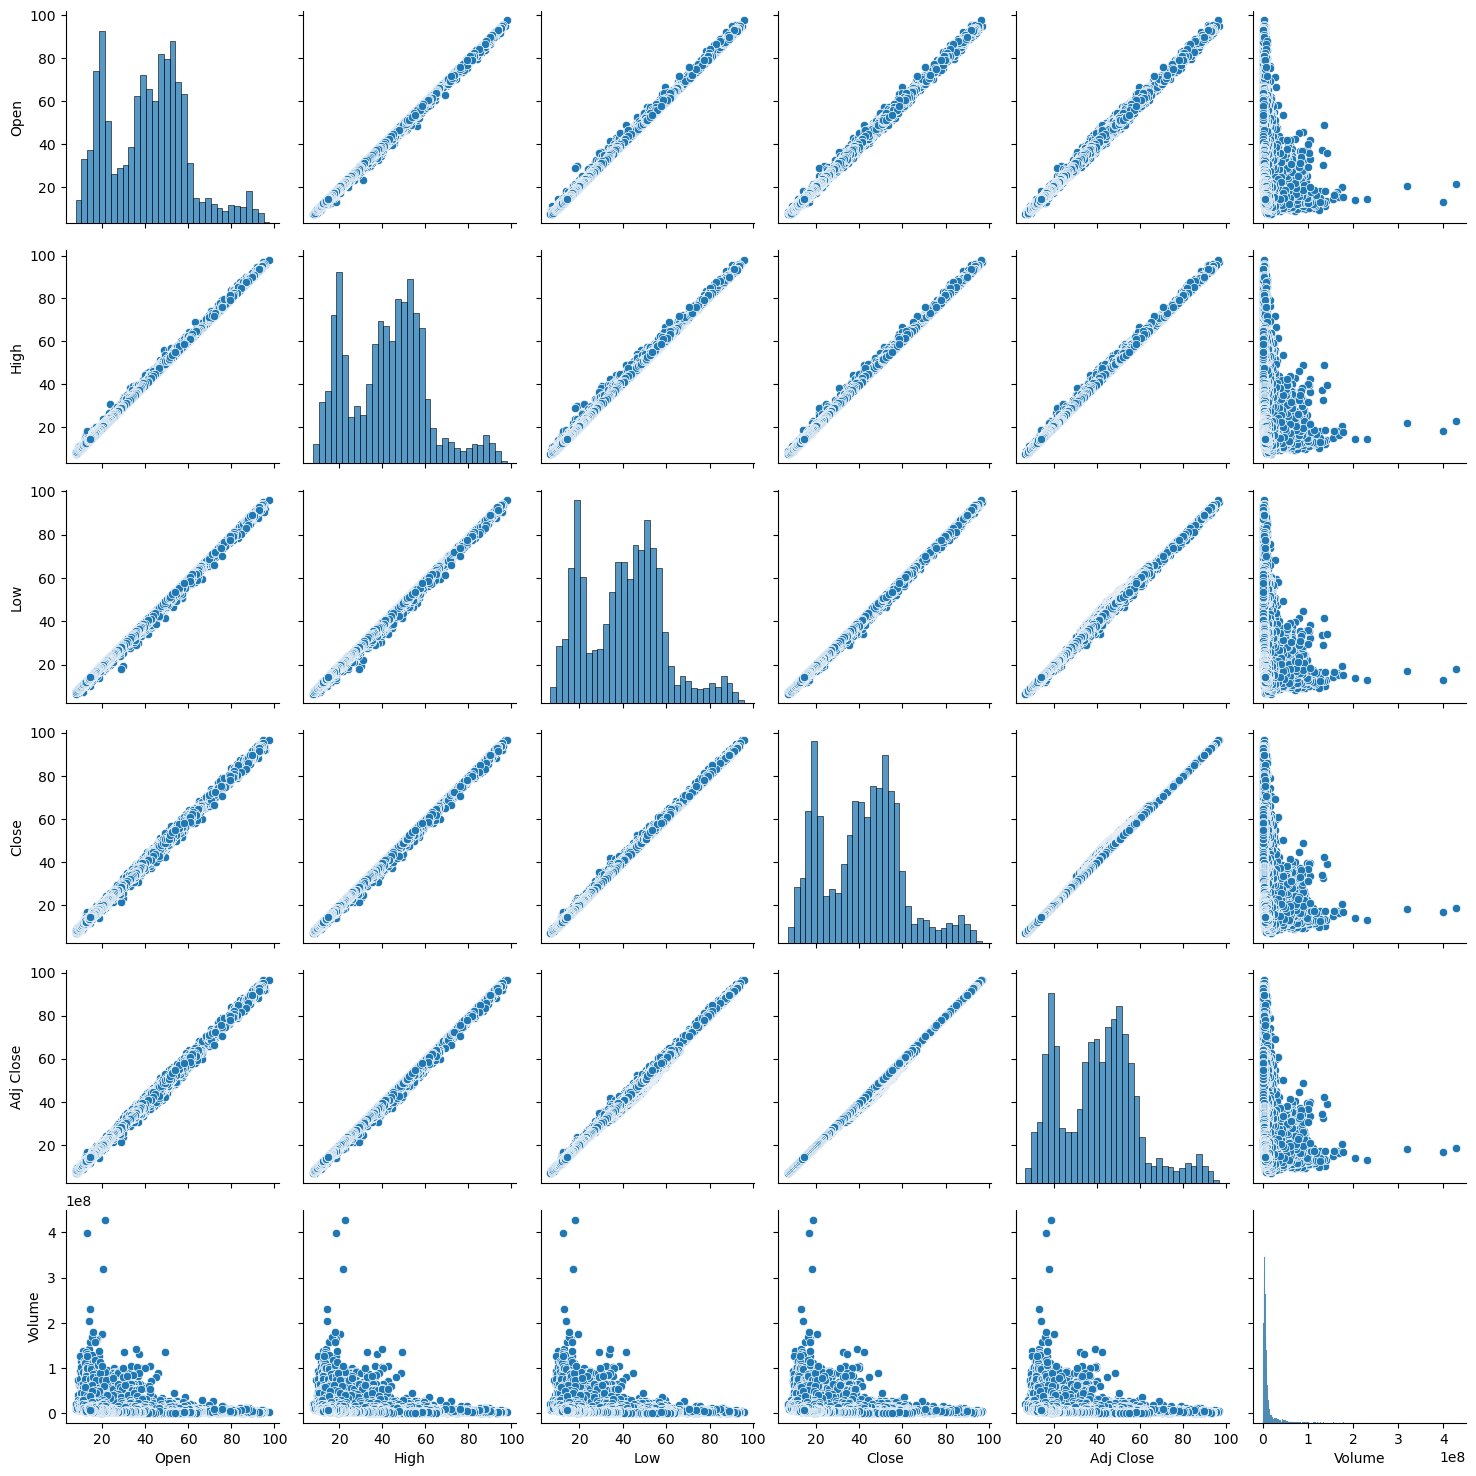

In [30]:
sns.pairplot(s.loc[:, 'Open':'Volume'])
# save the pairplot
plt.savefig('../output/reports/figures/stock_pairplot.png', dpi=300)
plt.show()


The distributions of 'Open', 'High', 'Low', 'Close', and 'Adj Close' appear to be bimodal, with a peaks around $20 and $50 for each. Additionally, 'Open', 'High', 'Low', 'Close', and 'Adj Close' are **extremely** correlated--the scatterplots are pretty much a line for all of them. 'Volume' appears to follow a power law distribution, with a standard deviation that is almost twice the mean and a median value that is about half the mean value.

In [15]:
# get top correlations
display(get_corr(s))

correlations
Open      High         0.99950198
Low       Close        0.99948432
High      Close        0.99943462
Open      Low          0.99930753
High      Low          0.99912751
Open      Close        0.99892804
Close     Adj Close    0.99863852
High      Adj Close    0.99824760
Low       Adj Close    0.99797033
Open      Adj Close    0.99759818
Low       Volume      -0.32953479
Close     Volume      -0.32268943
Open      Volume      -0.32169161
Adj Close Volume      -0.31969116
High      Volume      -0.31574327

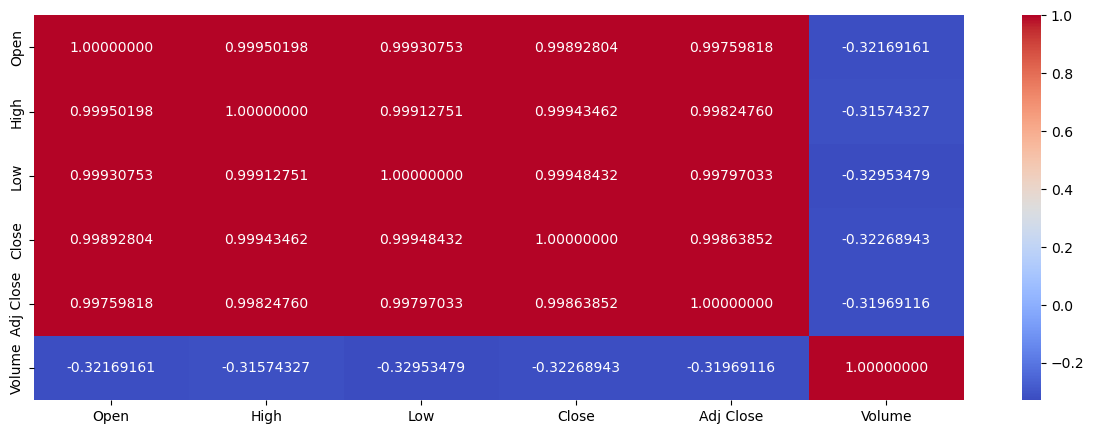

In [16]:

# format to add decimals or it is all rounded to 1
sns.heatmap(s.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.8f')
# make it bigger
plt.gcf().set_size_inches(15, 5)
# save the heatmap
plt.savefig('../output/reports/figures/stock_heatmap.png', dpi=300)
plt.show()


'Open', 'High', 'Low', 'Close', and 'Adj Close' are all highly correlated with each other. We will only use 'Adj Close' and 'Volume' in our analysis, so we don't have to worry about multicollinearity too much. 

### 2a. Looking at Flight_Delay_2016_2021

In [9]:
# InteractiveShell.ast_node_interactivity = "all"
InteractiveShell.ast_node_interactivity = "none"

In [25]:
# f is an alias for Flight_Delay_2016_2021
f = Flight_Delay_2016_2021.copy()
f.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101629 entries, 0 to 101628
Data columns (total 21 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   year                 101629 non-null  int64  
 1   month                101629 non-null  int64  
 2   carrier              101629 non-null  object 
 3   carrier_name         101629 non-null  object 
 4   airport              101629 non-null  object 
 5   airport_name         101629 non-null  object 
 6   arr_flights          101457 non-null  float64
 7   arr_del15            101264 non-null  float64
 8   carrier_ct           101457 non-null  float64
 9   weather_ct           101457 non-null  float64
 10  nas_ct               101457 non-null  float64
 11  security_ct          101457 non-null  float64
 12  late_aircraft_ct     101457 non-null  float64
 13  arr_cancelled        101457 non-null  float64
 14  arr_diverted         101457 non-null  float64
 15  arr_delay        

In [26]:
# display a sample of f
display(f.sample(n=5))

year  month carrier              carrier_name airport  \
23454  2020     10      B6           JetBlue Airways     RDU   
24580  2020      9      AA    American Airlines Inc.     CAE   
98635  2016      3      DL      Delta Air Lines Inc.     CHS   
74754  2018      2      EV  ExpressJet Airlines Inc.     JAN   
15892  2021      3      G4             Allegiant Air     OGD   

                                            airport_name  arr_flights  \
23454   Raleigh/Durham, NC: Raleigh-Durham International  94.00000000   
24580                Columbia, SC: Columbia Metropolitan  14.00000000   
98635       Charleston, SC: Charleston AFB/International 368.00000000   
74754  Jackson/Vicksburg, MS: Jackson Medgar Wiley Ev... 144.00000000   
15892                          Ogden, UT: Ogden-Hinckley   9.00000000   

        arr_del15  carrier_ct  weather_ct  ...  security_ct  late_aircraft_ct  \
23454  8.00000000  1.98000000  0.00000000  ...   0.00000000        2.20000000   
24580  4.00000000  3.74000000  0.00000000  ...   0.00000000        0.26000000   
98635 32.00000000 16.34000000  2.80000000  ...   0.00000000        6.01000000   
74754 19.00000000  5.90000000  1.29000000  ...   0.00000000        7.09000000   
15892  1.00000000  0.95000000  0.00000000  ...   0.00000000        0.00000000   

       arr_cancelled  arr_diverted     arr_delay  carrier_delay  \
23454     0.00000000    0.00000000  340.00000000    88.00000000   
24580     1.00000000    0.00000000  267.00000000   250.00000000   
98635     0.00000000    0.00000000 2019.00000000   904.00000000   
74754     0.00000000    1.00000000  941.00000000   305.00000000   
15892     0.00000000    0.00000000   19.00000000    18.00000000   

       weather_delay    nas_delay  security_delay  late_aircraft_delay  
23454     0.00000000 153.00000000      0.00000000          99.00000000  
24580     0.00000000   0.00000000      0.00000000          17.00000000  
98635   676.00000000 228.00000000      0.00000000         211.00000000  
74754   183.00000000 190.00000000      0.00000000         263.00000000  
15892     0.00000000   1.00000000      0.00000000           0.00000000  

[5 rows x 21 columns]

In [27]:
# display the descriptive statistics of f
display(f.drop(columns=['month']).describe().drop(index='count'))


year    arr_flights     arr_del15    carrier_ct   weather_ct  \
mean 2018.80266459   351.91027726   59.29698610   18.10126507   2.03407099   
std     1.63561052   977.46284725  164.90089380   45.41076393   6.69895952   
min  2016.00000000     1.00000000    0.00000000    0.00000000   0.00000000   
25%  2018.00000000    45.00000000    5.00000000    1.90000000   0.00000000   
50%  2019.00000000    93.00000000   15.00000000    5.28000000   0.21000000   
75%  2020.00000000   239.00000000   40.00000000   14.53000000   1.62000000   
max  2021.00000000 21977.00000000 4176.00000000 1242.16000000 226.00000000   

            nas_ct  security_ct  late_aircraft_ct  arr_cancelled  \
mean   18.23482451   0.14559025       20.66847581     7.44563707   
std    60.59124349   0.68487578       63.47193192    49.70008898   
min     0.00000000   0.00000000        0.00000000     0.00000000   
25%     1.00000000   0.00000000        1.00000000     0.00000000   
50%     3.38000000   0.00000000        4.05000000     1.00000000   
75%    10.33000000   0.00000000       13.11000000     3.00000000   
max  1884.42000000  41.97000000     1531.81000000  4951.00000000   

      arr_diverted       arr_delay   carrier_delay  weather_delay  \
mean    0.81015603   3847.38391634   1287.13411593   208.40234779   
std     3.56718253  11721.48167796   3814.19566775   783.22866659   
min     0.00000000      0.00000000      0.00000000     0.00000000   
25%     0.00000000    266.00000000     86.00000000     0.00000000   
50%     0.00000000    873.00000000    316.00000000    11.00000000   
75%     1.00000000   2549.00000000    981.00000000   128.00000000   
max   154.00000000 429194.00000000 196944.00000000 28294.00000000   

           nas_delay  security_delay  late_aircraft_delay  
mean    883.00887075      7.02003805        1461.81141764  
std    3511.60301525     41.54676066        4624.14405532  
min       0.00000000      0.00000000           0.00000000  
25%      27.00000000      0.00000000          44.00000000  
50%     125.00000000      0.00000000         262.00000000  
75%     415.00000000      0.00000000         940.00000000  
max  112018.00000000   3760.00000000      147167.00000000

In [28]:
f_null = f[f.isnull().any(axis=1)]
# find the number of null values in each column
display(pd.DataFrame(f_null.isnull().sum()).rename(
    columns={0: 'count of null values in each column'}))


count of null values in each column
year                                                   0
month                                                  0
carrier                                                0
carrier_name                                           0
airport                                                0
airport_name                                           0
arr_flights                                          172
arr_del15                                            365
carrier_ct                                           172
weather_ct                                           172
nas_ct                                               172
security_ct                                          172
late_aircraft_ct                                     172
arr_cancelled                                        172
arr_diverted                                         172
arr_delay                                            172
carrier_delay                                        172
weather_delay                                        172
nas_delay                                            172
security_delay                                       172
late_aircraft_delay                                  172

In [29]:

# get the value counts of the number of nulls in each row
display(pd.DataFrame(f_null.isnull().sum(axis=1).value_counts()).rename(
    columns={0: 'frequency of number of null values in each row with any null values'}))

# replace all null values with zero
f = f.fillna(0)


frequency of number of null values in each row with any null values
1                                                 193                  
15                                                172

The delay data covers the time period 2016 to 2021, and this table has 101629 entries and 21 columns. Additionally, there are 365 rows in this table that contain null values. 

We will be replacing missing values with 0. The missing values appear to follow a pattern where either 1 or 15 of the values are missing in each row. There are no rows where the value for 'arr_flights' is 0, so we believe that data is not entered for any of the 15 columns when 'arr_flights' is zero. Additionally, rows that are only missing 'arr_del15' values typically correspond to very small 'arr_flights' values, so it seems likely that the value is 0 for null 'arr_del15' values as well (as there will be less 15 minute delays when there are fewer flights).

We are most interested in the ‘year’, ‘month’, ‘carrier’, ‘airport’, 'arr_flight', and ‘\*_ct’ columns. The 'year' and 'month' columns describe the date that the airport/airline data was collected. The 'carrier' column indicates the airline that was tracked. The 'airport' column indicates the airport that was tracked. The 'arr_flight' indicates the number of flights from the specified airline that arrived at the specified airport. The '*_count' columns indicate the frequency of a specific type of delay (like weather or carrier/airline issues). The '*_count' column is an decimal number because a single delay can be explained by multiple factors; for instance, the captain could be late (a carrier delay) and the weather could be horrible (a weather), resulting in one delay split of .5 for carrier_ct and .5 for weather_ct.

These variables together describe the number of different types of delays that happened on a monthly basis at each airport for each carrier (airline). We will use this information in combination with stock return data later on.




### 2b. Visualizing Flight_Delay_2016_2021

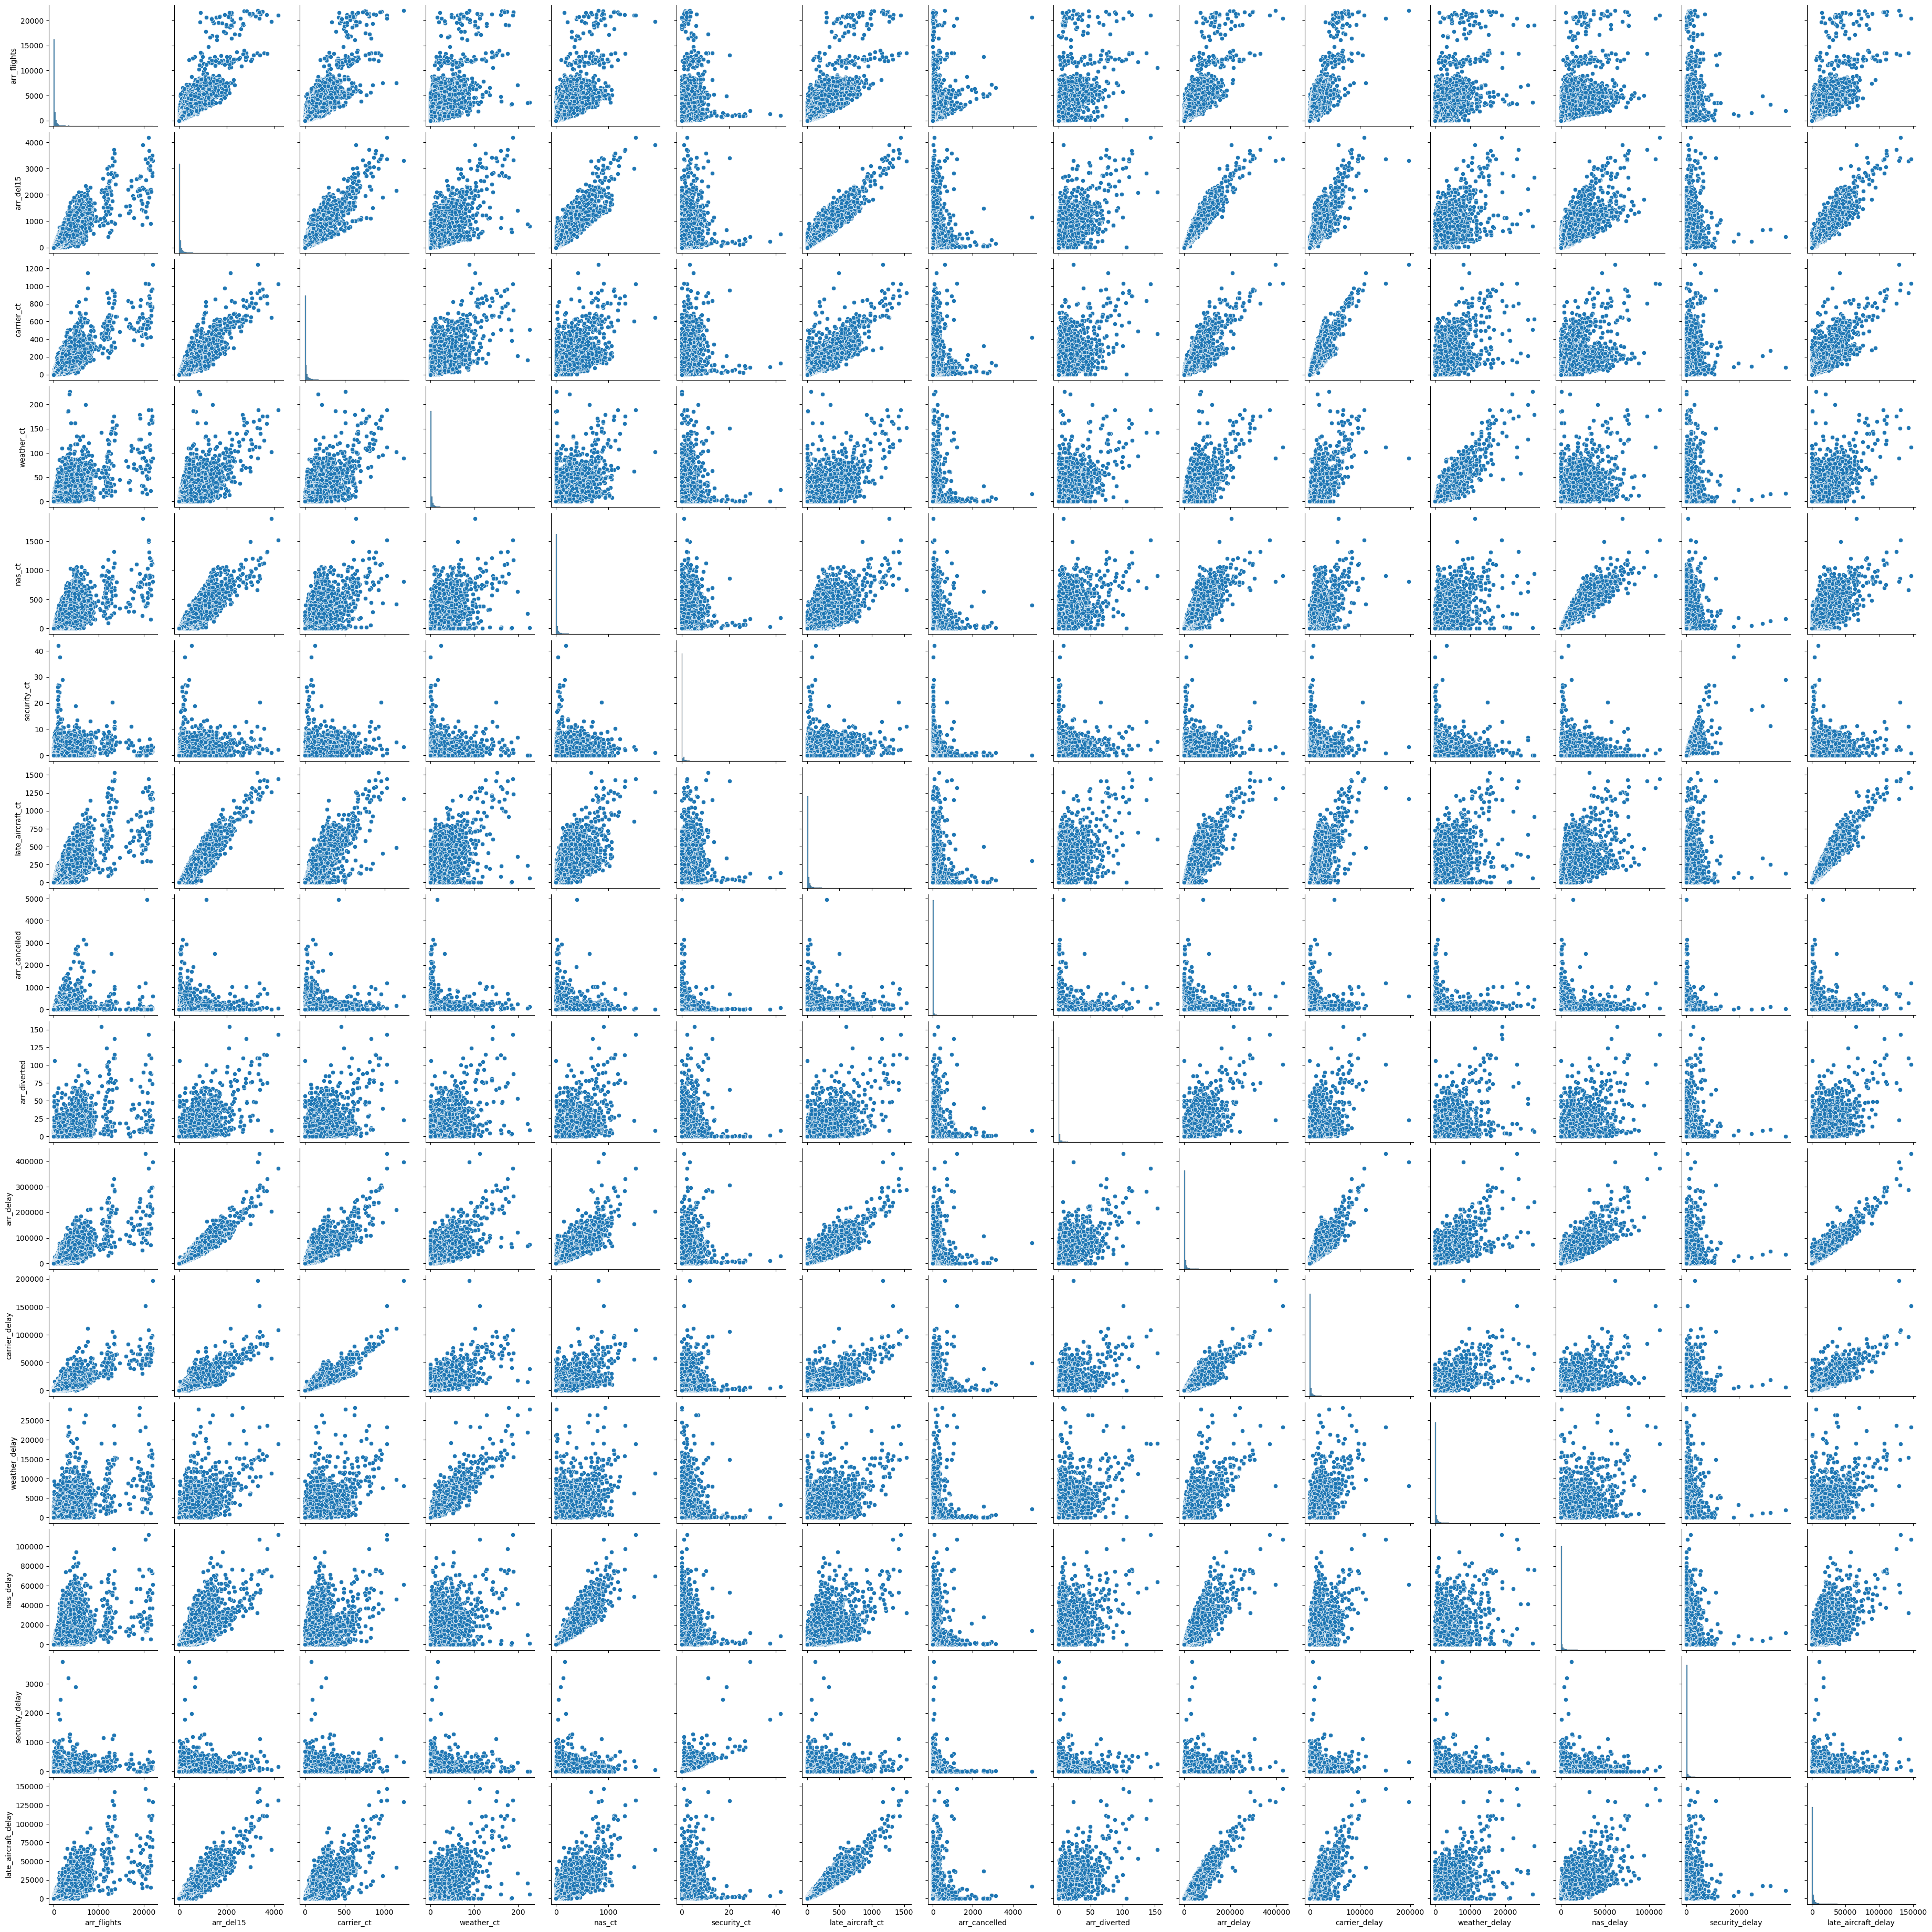

In [30]:
# get all numerical columns
num_data = f.loc[:, 'arr_flights':'late_aircraft_delay']
sns.pairplot(num_data, diag_kws=dict(bins=100))
# save the figure
plt.savefig('../output/reports/figures/flight_delay_pairplot.png', dpi=300)
plt.show()

There is a lot colinearity in these variables. For instance, 'late_aircraft_ct' and 'late_aircraft_delay' appear to be highly correlated, but they measure the same event (one airplane delaying another airplane) in a slightly different way. 'late_aircraft_ct' is the _count_ of aircraft delays due to another flight on the same aircraft being delayed, and 'late_aircraft_delay' is the _number of minutes_ of delay due to another flight on the same aircraft being delayed. 

All of the variables in this table appear to follow a power law distribution. The standard deviation for these variables is far greater than the mean values (2-4x greater), and the median value is much less than the mean. We might log-normalize these variables later on.

In [31]:
display(get_corr(f).head(20))

correlations
late_aircraft_ct late_aircraft_delay    0.96916890
arr_del15        arr_delay              0.96818223
arr_delay        late_aircraft_delay    0.96306365
arr_del15        late_aircraft_ct       0.96081937
                 late_aircraft_delay    0.95301032
nas_ct           nas_delay              0.94405783
arr_del15        carrier_ct             0.93932147
arr_delay        carrier_delay          0.93725097
carrier_ct       carrier_delay          0.93492178
weather_ct       weather_delay          0.92129009
late_aircraft_ct arr_delay              0.91956617
arr_del15        nas_ct                 0.91741404
arr_flights      arr_del15              0.90924010
carrier_ct       late_aircraft_ct       0.90665665
arr_del15        carrier_delay          0.90393677
nas_ct           arr_delay              0.90246910
carrier_ct       arr_delay              0.89830666
arr_flights      carrier_ct             0.89803517
carrier_delay    late_aircraft_delay    0.88848108
carrier_ct       late_aircraft_delay    0.88490330

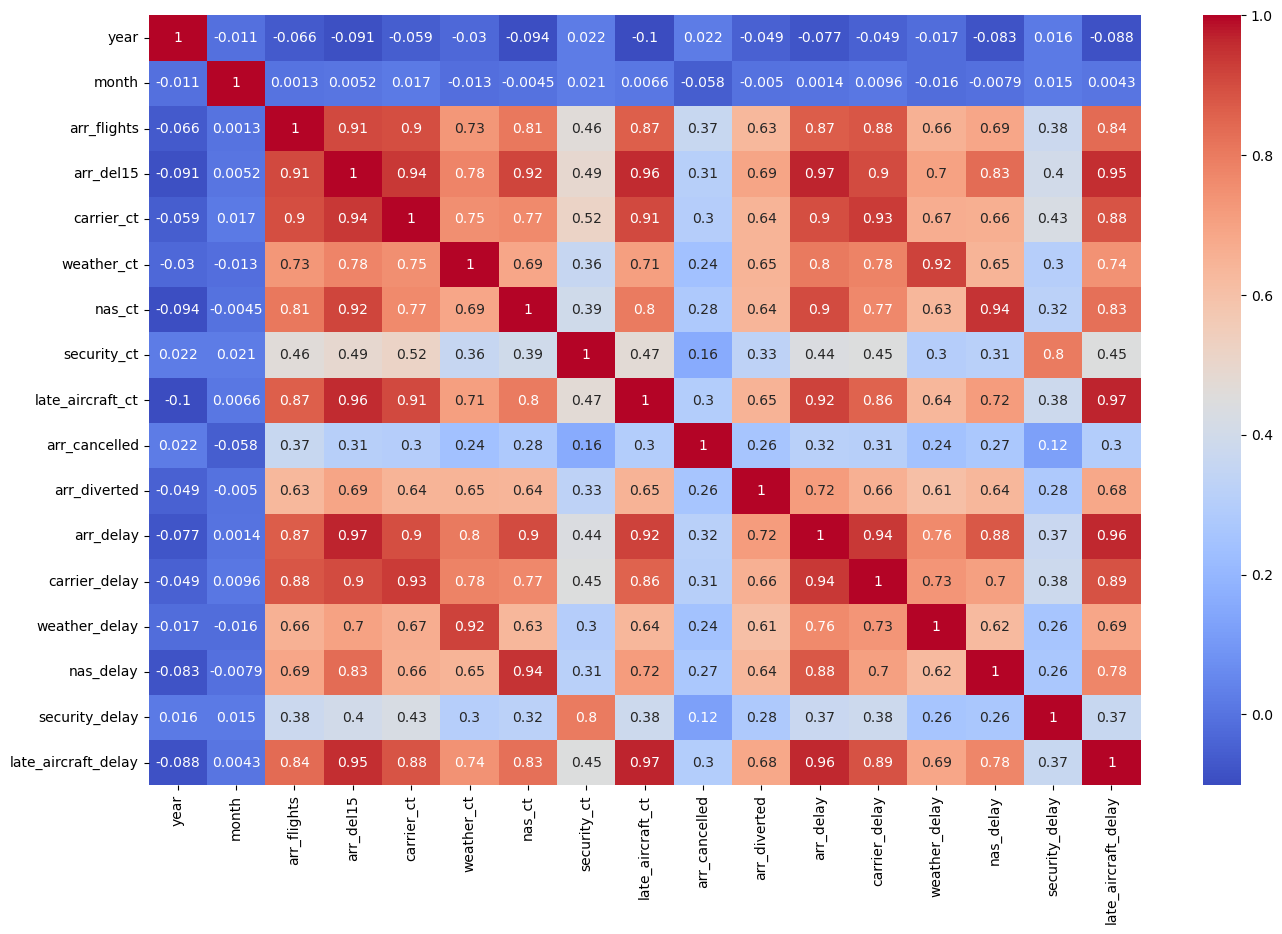

In [32]:

sns.heatmap(f.corr(numeric_only=True), annot=True, cmap='coolwarm')
# make it bigger
plt.gcf().set_size_inches(16, 10)
# save the figure
plt.savefig('../output/reports/figures/flight_delay_corr.png', dpi=300)
plt.show()


There are a lot of highly correlated features. This was also shown in the pairplot. We will need to be careful about which features we use in later analysis. We will likely use PCA to reduce the dimensionality of the data.

### 3. Looking at Secondary Tables (Metadata_Flight_Delay_2016_2021, Airlines, Airports)

These are less important--they are just column descriptions and connectors for the main tables.

### 3a. Looking at Metadata_Flight_Delay_2016_2021

In [35]:
# md is an alias for Metadata_Flight_Delay_2016_2021
md = Metadata_Flight_Delay_2016_2021.copy()
md.set_index('SYS_FIELD_NAME', inplace=True)
md = md.to_dict()['FIELD_DESC']
# md can be used to get a description of a column in Flight_Delay_2016_2021
# it has been converted to a dictionary for easy access
display(md)


{'year': 'Year of the data',
 'month': 'Month of the data',
 'carrier': 'Abbreviation of airline',
 'carrier_name': 'Name of airline',
 'airport': 'Airport code',
 'airport_name': 'Name of airport',
 'arr_flights': 'Number of flights arriving at airport',
 'arr_del15': 'Number of flights more than 15 minutes late',
 'carrier_ct': 'Number of flights delayed due to air carrier. (e.g. no crew)',
 'weather_ct': 'Number of flights due to weather.',
 'nas_ct': 'Number of flights delayed due to National Aviation System (e.g. heavy air traffic).',
 'security_ct': 'Number of flights canceled due to a security breach.',
 'late_aircraft_ct': 'Number of flights delayed as a result of another flight on the same aircraft delayed',
 'arr_cancelled': 'Number of cancelled flights',
 'arr_diverted': 'Number of flights that were diverted',
 'arr_delay': 'Total time (minutes) of delayed flight.',
 'carrier_delay': 'Total time (minutes) of delay due to air carrier',
 'weather_delay': 'Total time (minutes) 

This data has been converted into a dictionary, with the keys corresponding to columns in the delay table. The values are detailed descriptions of the corresponding delay table variable.


### 3b. Looking at Airlines

In [36]:
# al is an alias for Airlines
# this will be used for merging tables later on
al = Airlines.copy()
al.info()
al.sample(n=5)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1712 entries, 0 to 1711
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Code         1711 non-null   object
 1   Description  1712 non-null   object
dtypes: object(2)
memory usage: 26.9+ KB


This data stores abbreviation/full-name pairs for airlines. This table has 6654 entries and 2 columns. There are no null values.

### 3c. Looking at Airports

In [37]:
# ap is an alias for Airports
# this will be used for merging tables later on
ap = Airports.copy()
ap.info()
ap.sample(n=5)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6654 entries, 0 to 6653
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Code         6654 non-null   object
 1   Description  6654 non-null   object
dtypes: object(2)
memory usage: 104.1+ KB


This data stores abbreviation/full-name pairs for airlines. This table has 6654 entries and 2 columns. There are no null values.

# Manipulating the Data

We want to aggregate the stock data by month to match the flight delay data. We also want to group by airlines in the delay data before merging--each row is currently representing a unique combination of airline AND airport, but the stock data only shows airline information. 

From there we can add monthly returns, filter out the years 2017 and 2022, and see how the data has changed pre and post pandemic.

In [38]:
s_ret = s.copy()
# convert Date to datetime
s_ret['Date'] = pd.to_datetime(s_ret['Date'])
# make a new column for the year and month
s_ret['year'] = s_ret['Date'].dt.year
s_ret['month'] = s_ret['Date'].dt.month
# drop the columns we don't need and get the last row for each month to get the monthly returns
s_group = s_ret.drop(columns=['Open', 'High', 'Low', 'Close', 'Date']).groupby(
    ['carrier_name', 'year', 'month']).last()
# get returns for each airline
s_group['return'] = s_group['Adj Close'].pct_change()
# drop the rows without returns. This is 2016 data, so we are not interested in it.
s_group = s_group.dropna().reset_index()
display(s_group[s_group['carrier_name'] == 'American Airlines Inc.'].head(5))


carrier_name  year  month Airline   Adj Close    Volume  \
0  American Airlines Inc.  2016      2     AAL 39.28836400   5791300   
1  American Airlines Inc.  2016      3     AAL 39.29795100   8138000   
2  American Airlines Inc.  2016      4     AAL 33.24179800  17807200   
3  American Airlines Inc.  2016      5     AAL 30.66625200   9618700   
4  American Airlines Inc.  2016      6     AAL 27.20657000  11148300   

       return  
0  0.05442068  
1  0.00024402  
2 -0.15410862  
3 -0.07747914  
4 -0.11281724

In [39]:
# create 2017 data
s_2017 = s_group[s_group['year']==2017].copy()
# create 2018 data
s_2021 = s_group[s_group['year']==2021].copy()

The sample output for Amerian Airlines looks correct. We will continue by grouping the delay data by airline, month, and year; and then merging with the stock data.

In [40]:
# drop the non-numerical columns for the groupby
airl = f.drop(columns=['carrier', 'airport', 'airport_name']).groupby(
    ['carrier_name', 'year', 'month']).sum(numeric_only=True).reset_index()
display(airl.head(5))


carrier_name  year  month    arr_flights     arr_del15  \
0  Alaska Airlines Inc.  2016      1 14205.00000000 1655.00000000   
1  Alaska Airlines Inc.  2016      2 13399.00000000 1293.00000000   
2  Alaska Airlines Inc.  2016      3 14781.00000000 1854.00000000   
3  Alaska Airlines Inc.  2016      4 14662.00000000 1520.00000000   
4  Alaska Airlines Inc.  2016      5 15385.00000000 1433.00000000   

    carrier_ct  weather_ct       nas_ct  security_ct  late_aircraft_ct  \
0 410.72000000 65.10000000 729.27000000   7.41000000      442.50000000   
1 390.42000000 27.14000000 541.18000000   9.62000000      324.68000000   
2 449.26000000 22.61000000 861.83000000  19.16000000      501.16000000   
3 382.61000000 11.59000000 747.71000000  11.68000000      366.39000000   
4 404.49000000 14.30000000 676.62000000  13.10000000      324.54000000   

   arr_cancelled  arr_diverted      arr_delay  carrier_delay  weather_delay  \
0   139.00000000   50.00000000 82680.00000000 23250.00000000  4421.00000000   
1    79.00000000   64.00000000 62154.00000000 22221.00000000  3002.00000000   
2   108.00000000   49.00000000 86850.00000000 25602.00000000  1156.00000000   
3    16.00000000   18.00000000 66048.00000000 20535.00000000   742.00000000   
4    33.00000000   31.00000000 60859.00000000 21270.00000000  1065.00000000   

       nas_delay  security_delay  late_aircraft_delay  
0 26665.00000000    286.00000000       28058.00000000  
1 16977.00000000    242.00000000       19712.00000000  
2 29075.00000000    591.00000000       30426.00000000  
3 23698.00000000    313.00000000       20760.00000000  
4 21388.00000000    319.00000000       16817.00000000

The groupby operation worked as expected. We will continue by merging the delay and stock data. We will perform an "inner" join, which will only keep the Airlines that are in both the stock and the delay data.

In [42]:
# join the two tables on carrier_name, year, and month
data = pd.merge(airl, s_group, on=['carrier_name', 'year', 'month'], how='inner')
data.head(5)

# filter for 2017
data17 = data[data.year == 2017]
data17.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 72 entries, 11 to 382
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   carrier_name         72 non-null     object 
 1   year                 72 non-null     int64  
 2   month                72 non-null     int64  
 3   arr_flights          72 non-null     float64
 4   arr_del15            72 non-null     float64
 5   carrier_ct           72 non-null     float64
 6   weather_ct           72 non-null     float64
 7   nas_ct               72 non-null     float64
 8   security_ct          72 non-null     float64
 9   late_aircraft_ct     72 non-null     float64
 10  arr_cancelled        72 non-null     float64
 11  arr_diverted         72 non-null     float64
 12  arr_delay            72 non-null     float64
 13  carrier_delay        72 non-null     float64
 14  weather_delay        72 non-null     float64
 15  nas_delay            72 non-null     flo

In [44]:
# filter for 2022
data21 = data[data.year == 2021]
data21.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 72 entries, 59 to 430
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   carrier_name         72 non-null     object 
 1   year                 72 non-null     int64  
 2   month                72 non-null     int64  
 3   arr_flights          72 non-null     float64
 4   arr_del15            72 non-null     float64
 5   carrier_ct           72 non-null     float64
 6   weather_ct           72 non-null     float64
 7   nas_ct               72 non-null     float64
 8   security_ct          72 non-null     float64
 9   late_aircraft_ct     72 non-null     float64
 10  arr_cancelled        72 non-null     float64
 11  arr_diverted         72 non-null     float64
 12  arr_delay            72 non-null     float64
 13  carrier_delay        72 non-null     float64
 14  weather_delay        72 non-null     float64
 15  nas_delay            72 non-null     flo

In [45]:
# display 2017 data
display(data17.head())


carrier_name  year  month    arr_flights      arr_del15  \
11  American Airlines Inc.  2017      1 73132.00000000 13999.00000000   
12  American Airlines Inc.  2017      2 67123.00000000  9046.00000000   
13  American Airlines Inc.  2017      3 78114.00000000 14113.00000000   
14  American Airlines Inc.  2017      4 73656.00000000 14819.00000000   
15  American Airlines Inc.  2017      5 77328.00000000 14699.00000000   

      carrier_ct   weather_ct        nas_ct  security_ct  late_aircraft_ct  \
11 4109.15000000 313.32000000 5666.77000000  47.63000000     3862.05000000   
12 2822.17000000 140.34000000 3729.77000000  12.39000000     2341.26000000   
13 4149.15000000 245.29000000 5346.33000000  32.49000000     4339.75000000   
14 3960.29000000 360.55000000 5765.05000000  25.18000000     4707.99000000   
15 3991.76000000 238.26000000 5929.17000000  28.71000000     4511.15000000   

    ...       arr_delay   carrier_delay  weather_delay       nas_delay  \
11  ... 775251.00000000 262291.00000000 32928.00000000 215165.00000000   
12  ... 505970.00000000 189352.00000000 15534.00000000 139540.00000000   
13  ... 804861.00000000 280480.00000000 17839.00000000 207236.00000000   
14  ... 950854.00000000 280228.00000000 28976.00000000 272635.00000000   
15  ... 867425.00000000 270284.00000000 17832.00000000 264601.00000000   

    security_delay  late_aircraft_delay  Airline   Adj Close    Volume  \
11   2494.00000000      262373.00000000      AAL 42.76024600  11719800   
12    454.00000000      161090.00000000      AAL 44.89885700   4935600   
13   1536.00000000      297770.00000000      AAL 40.96681200   5427700   
14   1100.00000000      367915.00000000      AAL 41.27672200  13358000   
15   1357.00000000      313351.00000000      AAL 46.98519900   4486100   

        return  
11 -0.05225950  
12  0.05001400  
13 -0.08757561  
14  0.00756490  
15  0.13829773  

[5 rows x 22 columns]

In [47]:
# display 2021 data
display(data21.head())

carrier_name  year  month    arr_flights     arr_del15  \
59  American Airlines Inc.  2021      1 38226.00000000 3927.00000000   
60  American Airlines Inc.  2021      2 34256.00000000 4404.00000000   
61  American Airlines Inc.  2021      3 47648.00000000 4657.00000000   
62  American Airlines Inc.  2021      4 52305.00000000 5769.00000000   
63  American Airlines Inc.  2021      5 61032.00000000 8909.00000000   

      carrier_ct   weather_ct        nas_ct  security_ct  late_aircraft_ct  \
59 1340.40000000 192.18000000 1697.08000000  24.82000000      672.51000000   
60 1458.74000000 444.41000000 1755.68000000  34.76000000      710.44000000   
61 1969.84000000 136.96000000 1543.51000000  48.94000000      957.71000000   
62 2186.60000000 197.42000000 1990.52000000  64.51000000     1329.95000000   
63 3197.08000000 518.76000000 2609.67000000  59.75000000     2523.68000000   

    ...       arr_delay   carrier_delay  weather_delay       nas_delay  \
59  ... 282797.00000000 115829.00000000 24452.00000000  78123.00000000   
60  ... 330128.00000000 126419.00000000 57584.00000000  69169.00000000   
61  ... 341967.00000000 156763.00000000 15362.00000000  70630.00000000   
62  ... 388003.00000000 172380.00000000 18915.00000000  78397.00000000   
63  ... 720308.00000000 281557.00000000 60163.00000000 134647.00000000   

    security_delay  late_aircraft_delay  Airline   Adj Close     Volume  \
59   1096.00000000       63297.00000000      AAL 17.17000000  113054800   
60   1273.00000000       75683.00000000      AAL 20.94000100   42397300   
61   1739.00000000       97473.00000000      AAL 23.90000000   29800300   
62   3825.00000000      114486.00000000      AAL 21.71999900   31608800   
63   2427.00000000      241514.00000000      AAL 24.24000000   30594400   

        return  
59  0.08877616  
60  0.21956907  
61  0.14135620  
62 -0.09121343  
63  0.11602215  

[5 rows x 22 columns]

This data appears to be in the correct form. Only the carrier_name, year, and month columns are categorical, and the rest are numerical values. This will be important for when we do PCA analysis later on. But now will we visualize the data to see if there are any obvious differences between the pre and post pandemic data.

# Analysis and Visualization of the Data

### Looking at Monthly Stock Returns for Airlines (Pre and Post Pandemic)

The merged delay and airline data only has 6 airlines, so we can examine the data for each airline individually. We will look at the monthly stock returns for each airline, and see if there are any obvious differences between the pre and post pandemic data. We will also conduct a one-sided permutation test to see if any differences in the median values of monthly stock returns for the pre and post pandemic data are statistically significant.

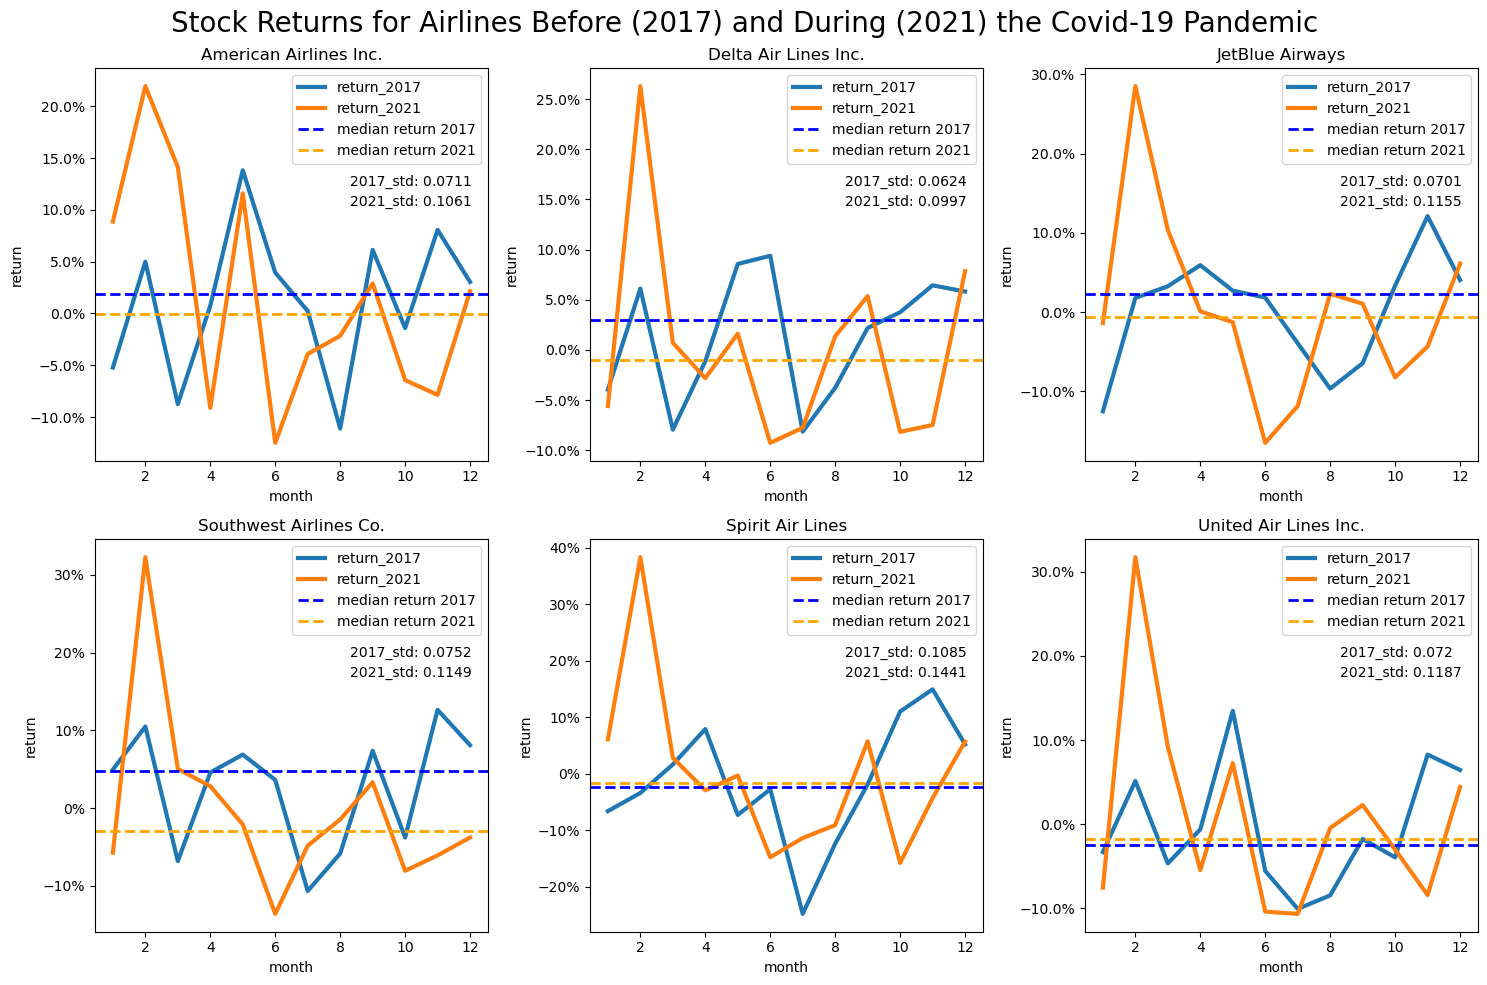

In [49]:
data_vis = pd.merge(data17, data21, on=[
                    'month', 'carrier_name'], how='inner', suffixes=('_2017', '_2021'))
# display(data_vis.head(5))

fig, ax = plt.subplots(2, 3, figsize=(15, 10))
unique_carrier_names = data_vis['carrier_name'].unique()
counter = 0

for i in range(2):
    for j in range(3):
        if counter < len(unique_carrier_names):
            carrier_name = unique_carrier_names[counter]
            sns.lineplot(data=data_vis[data_vis['carrier_name'] == carrier_name],
                         x='month', y='return_2017', ax=ax[i, j], label='return_2017')
            sns.lineplot(data=data_vis[data_vis['carrier_name'] == carrier_name],
                         x='month', y='return_2021', ax=ax[i, j], label='return_2021')
            ax[i, j].set_title(carrier_name)
            ax[i, j].lines[0].set_linewidth(3)
            ax[i, j].lines[1].set_linewidth(3)

            # Make the y-axis labels be percentage return
            ax[i, j].yaxis.set_major_formatter(PercentFormatter(1))

            # Draw 2 horizontal lines for the mean stock return for 2017 and 2021
            ax[i, j].axhline(data_vis[data_vis['carrier_name'] == carrier_name]
                             ['return_2017'].median(), color='blue', linestyle='--', linewidth=2)
            ax[i, j].axhline(data_vis[data_vis['carrier_name'] == carrier_name]
                             ['return_2021'].median(), color='orange', linestyle='--', linewidth=2)

            # annotate the standard deviation for 2017 and 2021
            ax[i, j].annotate(f"2017_std: {round(data_vis[data_vis['carrier_name']==carrier_name]['return_2017'].std(), 4)}", xy=(
                0.65, 0.7), xycoords='axes fraction')
            ax[i, j].annotate(f"2021_std: {round(data_vis[data_vis['carrier_name']==carrier_name]['return_2021'].std(), 4)}", xy=(
                0.65, 0.65), xycoords='axes fraction')

            # Create custom lines for the legend
            custom_lines = [Line2D([0], [0], color='blue', linestyle='--', lw=2),
                            Line2D([0], [0], color='orange', linestyle='--', lw=2)]

            # make the y label return
            ax[i, j].set_ylabel('return')

            # Combine the existing legend items with the custom lines
            ax[i, j].legend(ax[i, j].get_legend_handles_labels()[0] + custom_lines,
                            ['return_2017', 'return_2021', 'median return 2017', 'median return 2021'])

            counter += 1

plt.suptitle(
    'Stock Returns for Airlines Before (2017) and During (2021) the Covid-19 Pandemic', fontsize=20)
plt.tight_layout()
plt.savefig('../output/reports/figures/stock_returns.png', dpi=300)
plt.show()


In [51]:
# display the descriptive statistics for the returns
display(data_vis.groupby('carrier_name')[
        ['return_2017', 'return_2021']].describe().T)


carrier_name       American Airlines Inc.  Delta Air Lines Inc.  \
return_2017 count             12.00000000           12.00000000   
            mean               0.01210668            0.01439920   
            std                0.07114853            0.06244885   
            min               -0.11120634           -0.08150348   
            25%               -0.02364606           -0.03825176   
            50%                0.01903290            0.02968143   
            75%                0.05287706            0.06194868   
            max                0.13829773            0.09383260   
return_2021 count             12.00000000           12.00000000   
            mean               0.01636524            0.00173324   
            std                0.10612758            0.09974628   
            min               -0.12500004           -0.09270138   
            25%               -0.06790703           -0.07557641   
            50%               -0.00005435           -0.01053842   
            75%                0.09558766            0.02556332   
            max                0.21956907            0.26290833   

carrier_name       JetBlue Airways  Southwest Airlines Co.  Spirit Air Lines  \
return_2017 count      12.00000000             12.00000000       12.00000000   
            mean        0.00200086              0.02625629       -0.01524777   
            std         0.07014369              0.07520680        0.10849645   
            min        -0.12533448             -0.10669439       -0.24782188   
            25%        -0.04571979             -0.04303105       -0.06771930   
            50%         0.02265714              0.04765893       -0.02305139   
            75%         0.03522483              0.07547998        0.05884214   
            max         0.12114877              0.12643902        0.14936653   
return_2021 count      12.00000000             12.00000000       12.00000000   
            mean        0.00402693             -0.00186133        0.00015572   
            std         0.11546319              0.11487669        0.14410318   
            min        -0.16517408             -0.13618614       -0.15767158   
            25%        -0.05321040             -0.05819128       -0.09652255   
            50%        -0.00589343             -0.02943180       -0.01616959   
            75%         0.03251709              0.02941319        0.05705309   
            max         0.28521618              0.32294041        0.38319196   

carrier_name       United Air Lines Inc.  
return_2017 count            12.00000000  
            mean             -0.00415490  
            std               0.07203862  
            min              -0.10059801  
            25%              -0.04879342  
            50%              -0.02524929  
            75%               0.05463564  
            max               0.13473863  
return_2021 count            12.00000000  
            mean              0.00752199  
            std               0.11873089  
            min              -0.10652132  
            25%              -0.07755474  
            50%              -0.01727796  
            75%               0.05134002  
            max               0.31732927

There is a large positive outlier for all airlines' monthly stock returns for the month of February in 2021, but the median monthly stock return for each airline was lower in 2021 versus 2017 for 4 of the 6 airlines. Additionally, all airlines in 2021 had a negative median monthly stock return, whereas in 2017 only 2 airlines had negative median monthly stock returns. For every airline in 2021, the standard deviation of the monthly stock return was higher than in 2017, which means that the airline stocks were more volatile overall in pandemic times. 


We will now perform a permutation test to see if there is a statistically significant difference in the median monthly stock returns between 2017 and 2021. There appears to be some autocorrelation in the data (returns for 2017 and 2021 roughly move up and down together month to month), so we will permute the data on a monthly basis between 2017 and 2021 rather than permuting all values to keep the monthly structure of the data.

In [52]:
airline_permutations = [(carrier_name, get_permutation_list(data_vis[data_vis['carrier_name'] == carrier_name][[
                         'return_2017', 'return_2021']])) for carrier_name in unique_carrier_names]


100%|██████████| 10000/10000 [00:15<00:00, 655.03it/s]


The data we just generated are permutations of the median monthly stock return for each airline in 2017 and 2021. There are 2^12 = 4096 permutations, and each permutation is a different combination of 2017 and 2021 monthly stock returns (We generated 10000 randomly, so this should be sufficient to capture all possibilities). We will now look at the distribution of the median monthly stock returns for each airline in 2017 and 2021, and evaluate the statistical significance of these median stock return values.

In [53]:
# write the permutations to a pickle file
# so we don't have to run the above code again
with open('../output/models/airline_permutations.pkl', 'wb') as f:
    pickle.dump(airline_permutations, f)

In [54]:
# read pickle
with open('../output/models/airline_permutations.pkl', 'rb') as f:
    airline_permutations = pickle.load(f)

In [55]:
# these are the actual median returns for 2017 and 2021
median_returns = pd.DataFrame([(carrier_name, (k := data_vis[data_vis['carrier_name'] ==
                                                             carrier_name][['return_2017', 'return_2021']].median())[
                              0]-k[1], k[0], k[1]) for carrier_name in unique_carrier_names],
                              columns=['carrier_name', 'diff', 'median_2017', 'median_2021'])
display(median_returns)


carrier_name        diff  median_2017  median_2021
0  American Airlines Inc.  0.01908725   0.01903290  -0.00005435
1    Delta Air Lines Inc.  0.04021984   0.02968143  -0.01053842
2         JetBlue Airways  0.02855056   0.02265714  -0.00589343
3  Southwest Airlines Co.  0.07709073   0.04765893  -0.02943180
4        Spirit Air Lines -0.00688180  -0.02305139  -0.01616959
5   United Air Lines Inc. -0.00797133  -0.02524929  -0.01727796

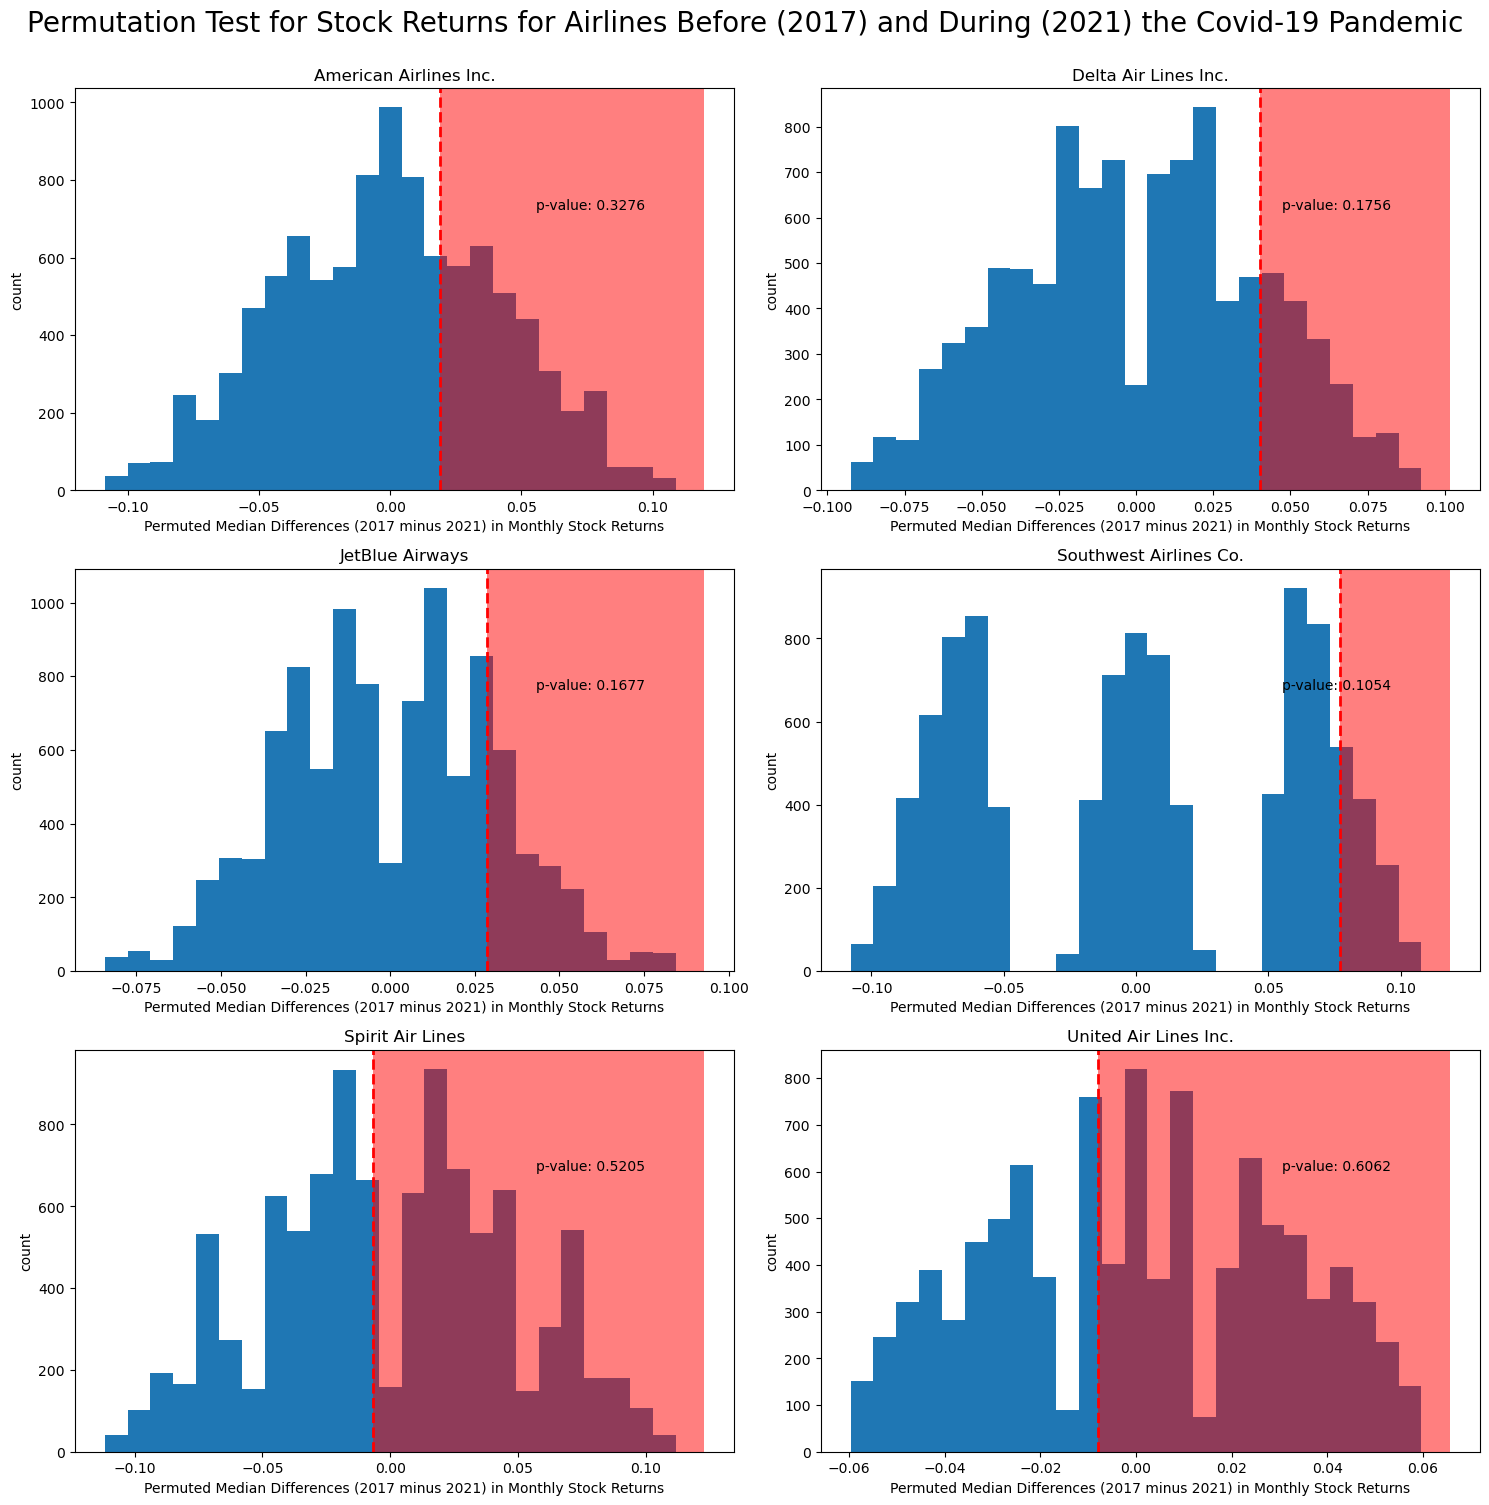

Airline    p-value
3  Southwest Airlines Co. 0.10540000
2         JetBlue Airways 0.16770000
1    Delta Air Lines Inc. 0.17560000
0  American Airlines Inc. 0.32760000
4        Spirit Air Lines 0.52050000
5   United Air Lines Inc. 0.60620000

In [57]:
display(plot_permutation_test(airline_permutations,
        median_returns).sort_values(by='p-value'))


None of the median monthly stock return values for 2017 vs 2021 are statistically significant at a 5% significance level. This means that we cannot reject the null hypothesis that the median monthly stock returns for each airline are the same in 2017 and 2021. The lowest p-value was .1075 for Southwest Airlines; which means that given random permutations of the data between the years 2017 and 2021 for Southwest Airlines, there is a 10.75% chance that the difference in medians between the years 2017 and 2021 is 0.077091 or more greater. We do not have sufficient evidence to say that the median monthly stock returns for each airline are different in 2017 and 2021. We will now look at the relationship between delay data and stock returns in 2017 and 2021.

### Normalizing the Data and Comparing Airline Delays

In [58]:
display(data17.describe())


year       month     arr_flights      arr_del15    carrier_ct  \
count   72.00000000 72.00000000     72.00000000    72.00000000   72.00000000   
mean  2017.00000000  6.50000000  58184.79166667 10472.94444444 2967.83694444   
std      0.00000000  3.47627776  33706.42703788  6994.01133141 1958.33436209   
min   2017.00000000  1.00000000  11443.00000000  1252.00000000  322.78000000   
25%   2017.00000000  3.75000000  25140.00000000  5557.25000000 1607.41250000   
50%   2017.00000000  6.50000000  60379.00000000  8862.50000000 2535.16000000   
75%   2017.00000000  9.25000000  79302.50000000 14027.50000000 4108.43000000   
max   2017.00000000 12.00000000 117975.00000000 31080.00000000 8555.61000000   

         weather_ct        nas_ct  security_ct  late_aircraft_ct  \
count   72.00000000   72.00000000  72.00000000       72.00000000   
mean   302.07597222 3334.39986111  18.62513889     3850.01166667   
std    297.74453078 1598.17333500  18.83027499     3599.91583102   
min      5.27000000  624.30000000   0.00000000      278.27000000   
25%     85.62250000 2130.57000000   6.34500000     1658.02500000   
50%    212.62500000 3153.90500000  13.46500000     2586.42000000   
75%    402.14500000 4452.80500000  27.30750000     4349.21750000   
max   1390.19000000 6567.81000000 111.81000000    15594.37000000   

       arr_cancelled  arr_diverted        arr_delay   carrier_delay  \
count    72.00000000   72.00000000      72.00000000     72.00000000   
mean    812.94444444  117.59722222  636841.56944444 189983.31944444   
std     847.54329133   80.75796908  373199.76254547 114281.03430971   
min       0.00000000    9.00000000   79587.00000000  22022.00000000   
25%     221.50000000   49.50000000  350813.00000000 102141.00000000   
50%     528.00000000  109.50000000  598796.00000000 186381.00000000   
75%    1028.75000000  172.75000000  859616.00000000 269300.00000000   
max    3450.00000000  330.00000000 1563821.00000000 514692.00000000   

        weather_delay       nas_delay  security_delay  late_aircraft_delay  \
count     72.00000000     72.00000000     72.00000000          72.00000000   
mean   28972.55555556 165084.05555556   1014.72222222      251786.91666667   
std    34796.53096636  72613.61450254   1177.83330825      190529.59022791   
min      358.00000000  31856.00000000      0.00000000       24455.00000000   
25%     6226.00000000 107183.00000000    285.25000000      123039.25000000   
50%    18023.00000000 161090.50000000    698.00000000      207106.00000000   
75%    38393.50000000 222620.00000000   1301.25000000      323780.75000000   
max   224027.00000000 337484.00000000   6114.00000000      834152.00000000   

        Adj Close            Volume      return  
count 72.00000000       72.00000000 72.00000000  
mean  47.02798244  4715561.11111111  0.00589339  
std   15.08088563  2783266.59979036  0.07641210  
min   18.53000100   550300.00000000 -0.24782188  
25%   41.93126125  2823500.00000000 -0.04798859  
50%   48.89721300  4556200.00000000  0.01806759  
75%   54.38844150  5738950.00000000  0.06122871  
max   79.66999800 13382200.00000000  0.14936653

In [59]:
display(data21.describe())

year       month     arr_flights      arr_del15     carrier_ct  \
count   72.00000000 72.00000000     72.00000000    72.00000000    72.00000000   
mean  2021.00000000  6.50000000  47082.45833333  8463.47222222  3279.32083333   
std      0.00000000  3.47627776  28500.38707864  7411.85367507  2940.56444513   
min   2021.00000000  1.00000000   8937.00000000  1139.00000000   235.84000000   
25%   2021.00000000  3.75000000  19060.50000000  3875.75000000  1300.26500000   
50%   2021.00000000  6.50000000  45988.50000000  6117.00000000  2400.89000000   
75%   2021.00000000  9.25000000  70377.25000000 10488.50000000  3898.57250000   
max   2021.00000000 12.00000000 104524.00000000 33405.00000000 12851.74000000   

        weather_ct        nas_ct  security_ct  late_aircraft_ct  \
count  72.00000000   72.00000000  72.00000000       72.00000000   
mean  244.71138889 2090.42680556  44.52986111     2804.48902778   
std   229.95761574 1073.10773211  31.70312898     3432.67919507   
min    12.34000000  434.42000000   0.00000000      183.77000000   
25%    84.64250000 1280.92500000  17.91750000      711.51250000   
50%   178.69000000 1836.74000000  43.04000000     1612.91500000   
75%   300.77000000 2623.56250000  70.10500000     3285.98250000   
max   980.03000000 4952.49000000 118.64000000    15146.53000000   

       arr_cancelled  arr_diverted        arr_delay   carrier_delay  \
count    72.00000000   72.00000000      72.00000000     72.00000000   
mean    815.01388889  112.44444444  527730.47222222 211722.91666667   
std    1048.91280392   95.75715895  427387.29564096 165630.89187384   
min       7.00000000   11.00000000   63597.00000000  12542.00000000   
25%     107.25000000   43.75000000  245377.25000000  80523.25000000   
50%     348.00000000   85.00000000  397237.00000000 153393.00000000   
75%     961.75000000  147.75000000  724297.25000000 285005.25000000   
max    3972.00000000  413.00000000 2006946.00000000 731863.00000000   

        weather_delay       nas_delay  security_delay  late_aircraft_delay  \
count     72.00000000     72.00000000     72.00000000          72.00000000   
mean   24567.75000000  92829.68055556   2187.91666667      196422.20833333   
std    23381.45789485  51634.01880948   1956.51595164      209061.84022639   
min      879.00000000  13667.00000000      0.00000000       11214.00000000   
25%     8881.00000000  57544.25000000    829.25000000       62424.25000000   
50%    16011.00000000  76000.00000000   1647.50000000      108682.00000000   
75%    28944.25000000 117559.00000000   3474.00000000      258760.25000000   
max   105262.00000000 235160.00000000  12472.00000000      989583.00000000   

        Adj Close             Volume      return  
count 72.00000000        72.00000000 72.00000000  
mean  34.78922044  13588134.72222222  0.00465697  
std   14.71178220  15211226.99474565  0.11328903  
min   13.42000000   2490700.00000000 -0.16517408  
25%   20.48499975   6350775.00000000 -0.07594921  
50%   36.45742600   9294150.00000000 -0.01420145  
75%   46.94934825  14474975.00000000  0.05121815  
max   62.45786700 113054800.00000000  0.38319196

The median number of arrivals for each airline was 60379.00 in 2017, and the median number of arrivals was 45988.50 in 2021. We cannot directly compare the number of delays because the number of arrivals differ between month, year, and airline. To adjust for this we will normalize the delay data by the number of arrivals for each airline for each year. We will not normalize the year, month, Adj Close, Volume, or return columns. There are only 6 airlines in common between the stock and delay data, so the merged stock and delay data can be examined granularly for each airline. 

To normalize the data, we will look at three different groupings. 

1. The first grouping is the different kinds of delay counts. 'arr_del15' is the total number of delays for each airline for each month, and the '\*_ct' columns are the number of delays for each airline for each month that were caused by a specific type of delay. We will normalize the '\*_ct' columns by the 'arr_del15' column, which will convert those columns into the probability that a flight was delayed for a specific reason given that it was delayed. 

2. The second grouping is the amount of time a flight was delayed due to a specific reason. 'arr_delay' is the total number of minutes of delay for each airline for each month, and the '*_delay' columns are the number of minutes of delay for each airline for each month that were caused by a specific type of delay. We will normalize the '\*_delay' columns by the 'arr_delay' column, which will convert those columns into the proportion of time spent waiting for a delay for each type of delay each month. 

3. The third grouping will be 'arr_del15' and 'arr_delay'. We will normalize will normalize these columns by the 'arr_flights' column to get the probability of a delay each month for each airline, and the average number of minutes of delay each month for each airline.

In [61]:
norm17 = data17.copy()
norm21 = data21.copy()

# normalize the data
del_ct = ['carrier_ct', 'weather_ct', 'nas_ct',
          'security_ct', 'late_aircraft_ct']
for i in del_ct:
    norm17[i] = norm17[i]/norm17['arr_del15']
    norm21[i] = norm21[i]/norm21['arr_del15']

display(norm17[del_ct].sample(n=5))


carrier_ct  weather_ct     nas_ct  security_ct  late_aircraft_ct
15   0.27156677  0.01620927 0.40337234   0.00195319        0.30690183
374  0.23060718  0.01581613 0.45699607   0.00000000        0.29658923
83   0.32835052  0.08275686 0.31543056   0.00051891        0.27294395
299  0.11899560  0.00889077 0.72272574   0.00124789        0.14813662
13   0.29399490  0.01738043 0.37882307   0.00230213        0.30750018

In [67]:
display(norm21[del_ct].sum(axis=1).sample(n=5))


69    1.00000090
354   1.00002693
212   0.99999498
208   0.99999676
423   1.00001075
dtype: float64

In [68]:
del_min = ['carrier_delay', 'weather_delay',
           'nas_delay', 'security_delay', 'late_aircraft_delay']
for i in del_min:
    norm17[i] = norm17[i]/norm17['arr_delay']
    norm21[i] = norm21[i]/norm21['arr_delay']
    

display(norm17[del_min+['arr_delay']].sample(n=5))


carrier_delay  weather_delay  nas_delay  security_delay  \
90      0.00000009     0.00000001 0.00000006      0.00000000   
18      0.00000003     0.00000000 0.00000002      0.00000000   
299     0.00000005     0.00000000 0.00000022      0.00000000   
232     0.00000001     0.00000000 0.00000001      0.00000000   
14      0.00000002     0.00000000 0.00000002      0.00000000   

     late_aircraft_delay   arr_delay  
90            0.00000007  7.17263133  
18            0.00000003 12.40337332  
299           0.00000006 15.48520286  
232           0.00000003 13.57071202  
14            0.00000003 12.90938959

In [69]:
display(norm21[del_min].sum(axis=1).sample(n=5))


277   0.00000043
133   0.00000082
210   0.00000009
63    0.00000012
425   0.00000006
dtype: float64

In [70]:
delays = ['arr_del15', 'arr_cancelled', 'arr_diverted', 'arr_delay']
for i in delays:
    norm17[i] = norm17[i]/norm17['arr_flights']
    norm21[i] = norm21[i]/norm21['arr_flights']

display(norm17[delays].sample(n=5))


arr_del15  arr_cancelled  arr_diverted  arr_delay
17  0.00000310     0.00000024    0.00000005 0.00021241
87  0.00000210     0.00000001    0.00000003 0.00013636
235 0.00000134     0.00000031    0.00000002 0.00006483
227 0.00000214     0.00000020    0.00000002 0.00010527
158 0.00001030     0.00000059    0.00000006 0.00079337

The first two groupings add to one, which is as expected since we were dividing by the count of the totals for each subtype. We can now make some visualization that directly compare month to month, year to year, and airline to airline.

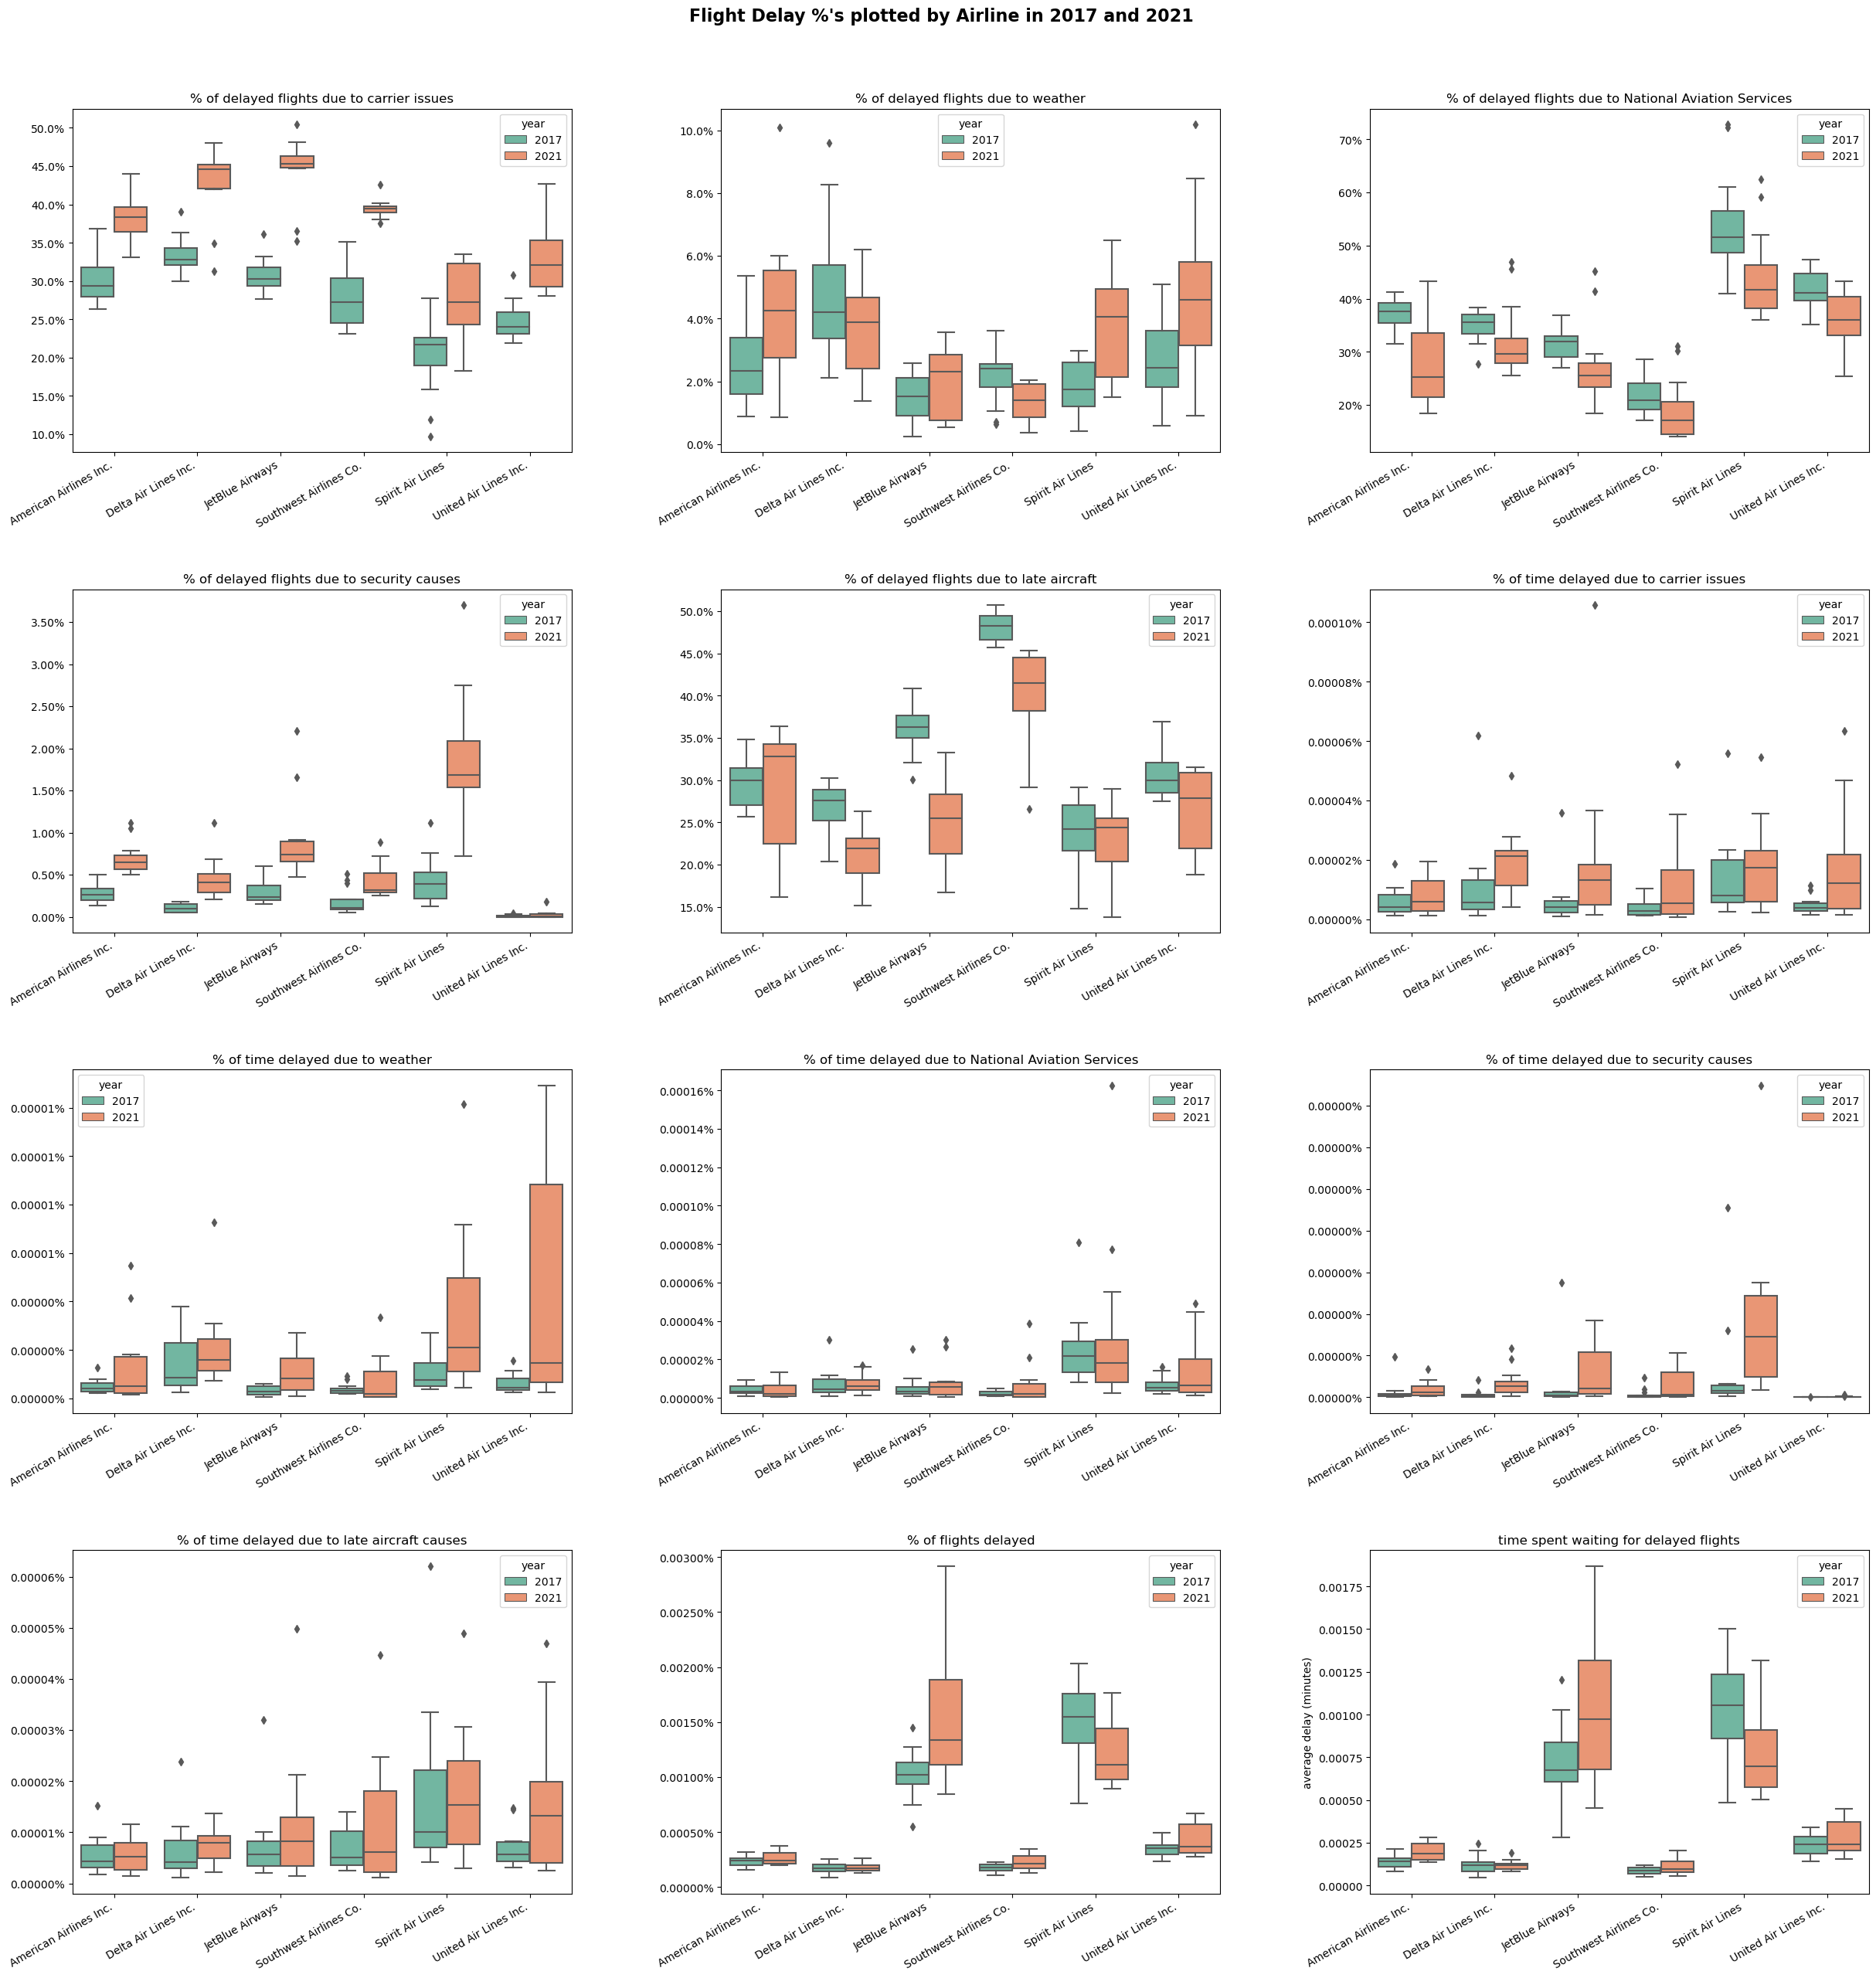

In [71]:
# create a new dataframe with the columns we want to plot
temp17 = norm17[['carrier_name']+del_ct +
                del_min+['arr_del15', 'arr_delay']].copy()
temp21 = norm21[['carrier_name']+del_ct +
                del_min+['arr_del15', 'arr_delay']].copy()
temp17['year'] = 2017
temp21['year'] = 2021
temp = pd.concat([temp17, temp21])

# create a list of the column names
cols = del_ct+del_min+['arr_del15', 'arr_delay']
titles = ['% of delayed flights due to carrier issues',
          '% of delayed flights due to weather',
          '% of delayed flights due to National Aviation Services',
          '% of delayed flights due to security causes',
          '% of delayed flights due to late aircraft',
          '% of time delayed due to carrier issues',
          '% of time delayed due to weather',
          '% of time delayed due to National Aviation Services',
          '% of time delayed due to security causes',
          '% of time delayed due to late aircraft causes',
          '% of flights delayed',
          'time spent waiting for delayed flights']

# create x_tick_labels
x_tick_labels = unique_carrier_names

# call the function
plot_boxplots(temp, cols, titles, 4, 3, 'Flight Delay %\'s plotted by Airline in 2017 and 2021',
              '', '', x_tick_labels, '')


The median % of flights delays is lower for all airlines. However, some airlines like JetBlue had greater than 50% of their flights delayed during one month in 2021, whereas in 2017 their highest % of flights delayed was around 36%. The increase in outer edges of the ranges for these airlines suggests that there is no

The median % of delayed flights due to carrier issues (i.e. Airline operational issues) is higher for every Airline in 2021 (pandemic) versus 2017 (pre-pandemic). It is also higher for % of time delayed due to carrier issues. We will perform another permutation test to see if these differences are statistically significant for each airline.

In [72]:
perm_temp = pd.merge(norm17, norm21, on=['month', 'carrier_name'], how='inner', suffixes=(
    '_2017', '_2021')).drop(columns=['year_2017', 'year_2021'])
display(perm_temp.sample(n=5))


carrier_name  month  arr_flights_2017  arr_del15_2017  \
62   United Air Lines Inc.      3    48497.00000000      0.00000362   
43  Southwest Airlines Co.      8   116158.00000000      0.00000230   
54        Spirit Air Lines      7    14212.00000000      0.00001643   
27         JetBlue Airways      4    25191.00000000      0.00001030   
45  Southwest Airlines Co.     10   110262.00000000      0.00000133   

    carrier_ct_2017  weather_ct_2017  nas_ct_2017  security_ct_2017  \
62       0.26753881       0.01642992   0.39636171        0.00000000   
43       0.27527703       0.02542921   0.19663256        0.00091313   
54       0.09728149       0.02038577   0.72825196        0.00235383   
27       0.29048195       0.00817931   0.32297736        0.00257344   
45       0.31545959       0.00627205   0.20979642        0.00403023   

    late_aircraft_ct_2017  arr_cancelled_2017  ...  arr_delay_2021  \
62             0.31967310          0.00000028  ...      0.00015771   
43             0.50174936          0.00000025  ...      0.00014782   
54             0.15171187          0.00000206  ...      0.00131706   
27             0.37579253          0.00000059  ...      0.00086459   
45             0.46444170          0.00000005  ...      0.00013839   

    carrier_delay_2021  weather_delay_2021  nas_delay_2021  \
62          0.00000063          0.00000011      0.00000045   
43          0.00000001          0.00000000      0.00000000   
54          0.00000002          0.00000000      0.00000003   
27          0.00000015          0.00000003      0.00000007   
45          0.00000002          0.00000000      0.00000001   

    security_delay_2021  late_aircraft_delay_2021  Airline_2021  \
62           0.00000000                0.00000047           UAL   
43           0.00000000                0.00000002           LUV   
54           0.00000000                0.00000003          SAVE   
27           0.00000001                0.00000012          JBLU   
45           0.00000000                0.00000002           LUV   

   Adj Close_2021  Volume_2021  return_2021  
62    57.54000100     11023800   0.09225514  
43    49.52457000      6431200  -0.01464774  
54    26.84462500      4695000  -0.11366628  
27    20.36000100      7107200   0.00098333  
45    47.03739900      6079600  -0.08069224  

[5 rows x 40 columns]

In [73]:
carrier_permutations = [(carrier_name, get_permutation_list(perm_temp[perm_temp['carrier_name'] == carrier_name][[
                         'carrier_ct_2017', 'carrier_ct_2021']])) for carrier_name in unique_carrier_names]

100%|██████████| 10000/10000 [00:14<00:00, 693.79it/s]


In [74]:
# write to pickle
with open('../output/models/carrier_ct_permutations.pkl', 'wb') as f:
    pickle.dump(carrier_permutations, f)

In [75]:
# read pickle
with open('../output/models/carrier_ct_permutations.pkl', 'rb') as f:
    carrier_permutations = pickle.load(f)

In [76]:
# get the median values of the real data
carrier_ct_medians = pd.DataFrame([(carrier_name, (k := perm_temp[perm_temp['carrier_name'] == \
                                         carrier_name][['carrier_ct_2017', 'carrier_ct_2021']].median())[
    0]-k[1], k[0], k[1]) for carrier_name in unique_carrier_names],
    columns=['carrier_name', 'diff', 'median_2017', 'median_2021'])
display(carrier_ct_medians)


carrier_name        diff  median_2017  median_2021
0  American Airlines Inc. -0.08928989   0.29376329   0.38305318
1    Delta Air Lines Inc. -0.11746473   0.32832972   0.44579445
2         JetBlue Airways -0.15052341   0.30293805   0.45346146
3  Southwest Airlines Co. -0.12145725   0.27276139   0.39421863
4        Spirit Air Lines -0.05603531   0.21666733   0.27270264
5   United Air Lines Inc. -0.08162809   0.23971661   0.32134469

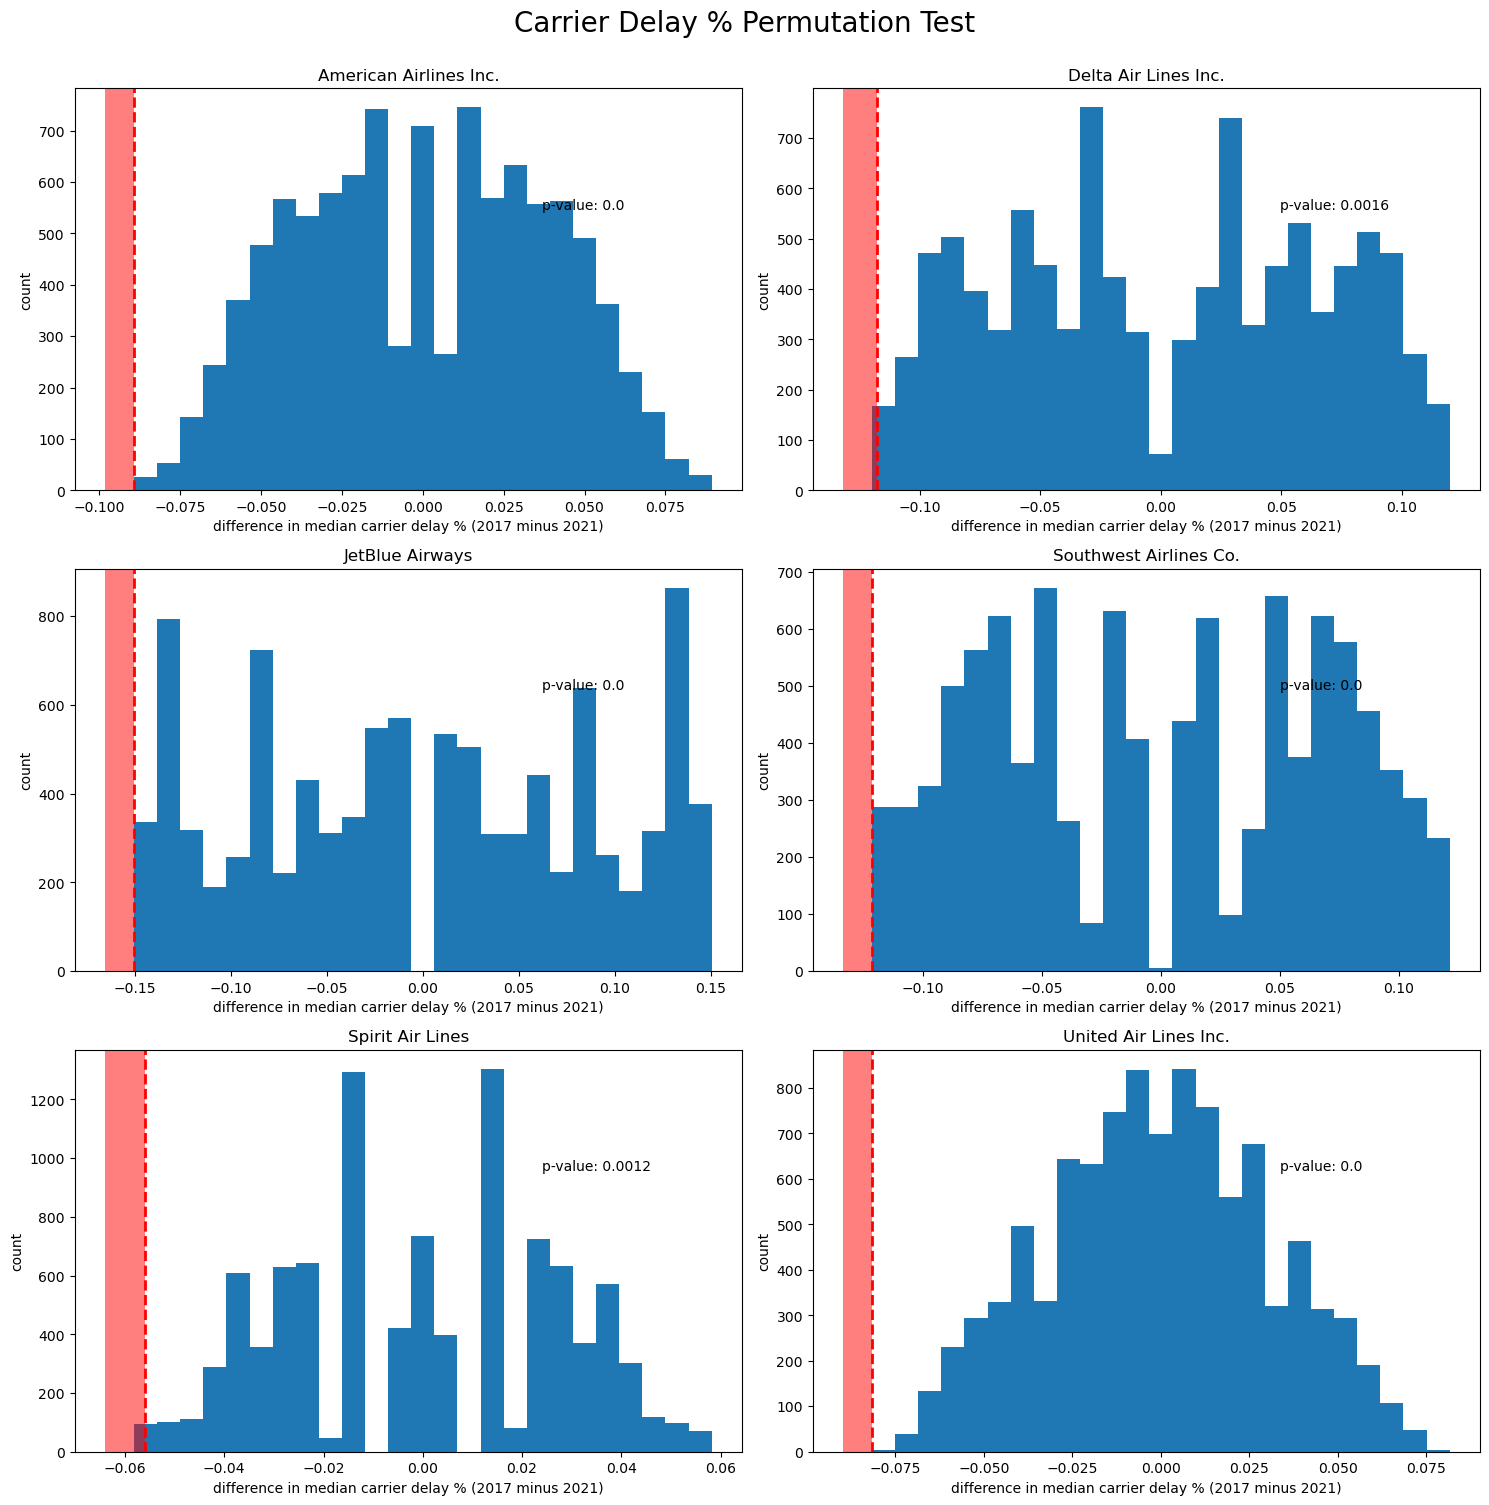

Airline    p-value
0  American Airlines Inc. 0.00000000
2         JetBlue Airways 0.00000000
3  Southwest Airlines Co. 0.00000000
5   United Air Lines Inc. 0.00000000
4        Spirit Air Lines 0.00120000
1    Delta Air Lines Inc. 0.00160000

In [77]:
display(plot_permutation_test(carrier_permutations, carrier_ct_medians, 
                              'carrier_ct_permutations.png', side='left',
        label='difference in median carrier delay % (2017 minus 2021)', 
        titles='Carrier Delay % Permutation Test').sort_values(by='p-value'))


The p-values for the permutation tests for all airlines are all less than .05, which means that we can reject the null hypothesis that the median % of flights delayed due to carrier issues is the same between 2017 and 2021 in favor of the alternative hypothesis that the median % of flights delayed due to carrier issues is higher in 2021 than in 2017 (because this is a one-sided permutation test). This means that the median % of flights delayed due to carrier issues is statistically significantly higher in 2021 than in 2017 for all airlines. 

### Looking at the Relationship between delays and monthly stock returns

In [78]:
# dropping volume and adj close because we are only interested in the return and delay data
dat17 = norm17.copy().drop(['Volume', 'Adj Close', 'year'], axis=1)
dat21 = norm21.copy().drop(['Volume', 'Adj Close', 'year'], axis=1)
for carrier_name in unique_carrier_names:
    # find where get_corr has a correlation with stock returns in the 2017 data
    (cor2017 := get_corr(dat17[dat17['carrier_name'] == carrier_name]).reset_index()[((W := get_corr(
        dat17[dat17['carrier_name'] == carrier_name]).reset_index())['level_0'] == 'return') | \
            (W['level_1'] == 'return')].reset_index(drop=True))
    cor2017['rank'] = cor2017.index
    # find where get_corr has a correlation with stock returns in the 2021 data
    (cor2021 := get_corr(dat21[dat21['carrier_name'] == carrier_name]).reset_index()[((W := get_corr(
        dat21[dat21['carrier_name'] == carrier_name]).reset_index())['level_0'] == 'return') | \
            (W['level_1'] == 'return')].reset_index(drop=True))
    cor2021['rank'] = cor2021.index
    # merge the two dataframes
    print(carrier_name)
    # add the rank different between the two years
    (mer := pd.merge(cor2017, cor2021, on=['level_0', 'level_1'], how='inner', 
                     suffixes=('_2017', '_2021')).sort_values(by='correlations_2021', 
                                                              ascending=False, key=abs).assign(
        rank_diff=lambda x: x['rank_2017']-x['rank_2021'])[['level_0', 'level_1', 'correlations_2017', 
                                                            'correlations_2021', 'rank_2017', 'rank_2021', 
                                                            'rank_diff']])
    # add one to rank_2017 and rank_2021 to make them 1-indexed
    mer['rank_2017'] += 1
    mer['rank_2021'] += 1
    display(mer)


American Airlines Inc.


level_0 level_1  correlations_2017  correlations_2021  \
7         weather_delay  return         0.25352483         0.72593575   
0           arr_flights  return        -0.41618647        -0.72296611   
12     late_aircraft_ct  return        -0.16736199        -0.71974120   
13               nas_ct  return         0.04973349         0.68097389   
9                 month  return         0.20999791        -0.54517537   
1             nas_delay  return         0.37665168         0.52842202   
8            weather_ct  return        -0.21080496         0.50282116   
2         carrier_delay  return         0.36931738         0.49647548   
3   late_aircraft_delay  return         0.36582796         0.45981173   
10           carrier_ct  return         0.20703592        -0.43836208   
15        arr_cancelled  return         0.01070245         0.40446630   
5          arr_diverted  return        -0.28666153         0.29512902   
14          security_ct  return        -0.01665583         0.26150179   
4        security_delay  return         0.30465810         0.18014839   
11            arr_delay  return        -0.17775356         0.09515474   
6             arr_del15  return        -0.25615628         0.08478119   

    rank_2017  rank_2021  rank_diff  
7           8          1          7  
0           1          2         -1  
12         13          3         10  
13         14          4         10  
9          10          5          5  
1           2          6         -4  
8           9          7          2  
2           3          8         -5  
3           4          9         -5  
10         11         10          1  
15         16         11          5  
5           6         12         -6  
14         15         13          2  
4           5         14         -9  
11         12         15         -3  
6           7         16         -9

Delta Air Lines Inc.


level_0 level_1  correlations_2017  correlations_2021  \
15        arr_cancelled  return        -0.04196453         0.86408484   
7         weather_delay  return         0.28347805         0.79550078   
4            weather_ct  return        -0.30757641         0.56434384   
13           carrier_ct  return         0.14173246        -0.55091652   
8           arr_flights  return        -0.27400358        -0.51227309   
0                nas_ct  return         0.34588805         0.46647212   
10     late_aircraft_ct  return        -0.23140626        -0.46105128   
12            arr_del15  return        -0.18308059         0.45367067   
11            arr_delay  return        -0.23096452         0.42269926   
1             nas_delay  return         0.33257912         0.24381677   
14          security_ct  return         0.08177412        -0.24031520   
2                 month  return         0.31177651        -0.22329622   
9        security_delay  return         0.23909556        -0.17689423   
6         carrier_delay  return         0.29785766         0.07812178   
5          arr_diverted  return        -0.30536113         0.04370618   
3   late_aircraft_delay  return         0.30924746        -0.03711147   

    rank_2017  rank_2021  rank_diff  
15         16          1         15  
7           8          2          6  
4           5          3          2  
13         14          4         10  
8           9          5          4  
0           1          6         -5  
10         11          7          4  
12         13          8          5  
11         12          9          3  
1           2         10         -8  
14         15         11          4  
2           3         12         -9  
9          10         13         -3  
6           7         14         -7  
5           6         15         -9  
3           4         16        -12

JetBlue Airways


level_0 level_1  correlations_2017  correlations_2021  \
8         arr_cancelled  return        -0.38212613         0.75022705   
6                nas_ct  return         0.42782362         0.54511425   
12          arr_flights  return        -0.24841576        -0.53560180   
7      late_aircraft_ct  return        -0.40114169        -0.46482069   
13           carrier_ct  return         0.20791869        -0.39520876   
10                month  return         0.30779198        -0.35324467   
15        weather_delay  return        -0.00037649         0.34194495   
9             arr_del15  return        -0.34040309         0.31917772   
2             nas_delay  return         0.54197313         0.31540051   
5   late_aircraft_delay  return         0.51283794         0.31108264   
1          arr_diverted  return        -0.56220745        -0.29635566   
0            weather_ct  return        -0.65019083        -0.29173152   
3         carrier_delay  return         0.52518799         0.27916201   
14          security_ct  return        -0.11803807        -0.20733040   
4        security_delay  return         0.51833172         0.12025137   
11            arr_delay  return        -0.27852704         0.07009969   

    rank_2017  rank_2021  rank_diff  
8           9          1          8  
6           7          2          5  
12         13          3         10  
7           8          4          4  
13         14          5          9  
10         11          6          5  
15         16          7          9  
9          10          8          2  
2           3          9         -6  
5           6         10         -4  
1           2         11         -9  
0           1         12        -11  
3           4         13         -9  
14         15         14          1  
4           5         15        -10  
11         12         16         -4

Southwest Airlines Co.


level_0 level_1  correlations_2017  correlations_2021  \
5         weather_delay  return         0.36678165         0.84727779   
14        arr_cancelled  return        -0.05991217         0.81203340   
8        security_delay  return         0.34823852         0.74619261   
2      late_aircraft_ct  return        -0.41811883        -0.70715861   
0           arr_flights  return        -0.66217766        -0.68255552   
15               nas_ct  return         0.05304868         0.65990797   
10          security_ct  return         0.23496550         0.63224353   
3         carrier_delay  return         0.41160286         0.45251568   
13                month  return         0.06139750        -0.44189453   
9             arr_delay  return        -0.32601875        -0.43800554   
7            weather_ct  return        -0.35448834         0.41610215   
1   late_aircraft_delay  return         0.45541980         0.37389193   
4             nas_delay  return         0.39473150         0.34579766   
6             arr_del15  return        -0.35624122        -0.32381087   
11         arr_diverted  return        -0.22289146        -0.04146605   
12           carrier_ct  return         0.20784278         0.03362028   

    rank_2017  rank_2021  rank_diff  
5           6          1          5  
14         15          2         13  
8           9          3          6  
2           3          4         -1  
0           1          5         -4  
15         16          6         10  
10         11          7          4  
3           4          8         -4  
13         14          9          5  
9          10         10          0  
7           8         11         -3  
1           2         12        -10  
4           5         13         -8  
6           7         14         -7  
11         12         15         -3  
12         13         16         -3

Spirit Air Lines


level_0 level_1  correlations_2017  correlations_2021  \
14        weather_delay  return         0.31444186         0.81965504   
1                nas_ct  return        -0.69901307         0.72957370   
9           arr_flights  return        -0.49736560        -0.72937952   
6      late_aircraft_ct  return         0.59234659        -0.71586612   
4         carrier_delay  return         0.65074682         0.56131615   
0            carrier_ct  return         0.77056188        -0.55187188   
3   late_aircraft_delay  return         0.67247638         0.54139988   
10            nas_delay  return         0.49620766         0.49893605   
13                month  return         0.31854491        -0.43554234   
5        security_delay  return         0.59845693         0.26108487   
11            arr_delay  return        -0.45109023        -0.25241095   
7           security_ct  return         0.55389113        -0.24922297   
12        arr_cancelled  return        -0.34000892         0.14235112   
15           weather_ct  return        -0.24032973        -0.12279910   
2          arr_diverted  return        -0.68069639        -0.10032608   
8             arr_del15  return        -0.51049002        -0.02670013   

    rank_2017  rank_2021  rank_diff  
14         15          1         14  
1           2          2          0  
9          10          3          7  
6           7          4          3  
4           5          5          0  
0           1          6         -5  
3           4          7         -3  
10         11          8          3  
13         14          9          5  
5           6         10         -4  
11         12         11          1  
7           8         12         -4  
12         13         13          0  
15         16         14          2  
2           3         15        -12  
8           9         16         -7

United Air Lines Inc.


level_0 level_1  correlations_2017  correlations_2021  \
4         arr_cancelled  return        -0.44433101         0.88613085   
14        weather_delay  return         0.11087238         0.54393308   
3            weather_ct  return        -0.45911818         0.48616103   
1      late_aircraft_ct  return        -0.56935126        -0.44936928   
10          security_ct  return        -0.35839108        -0.41739047   
5           arr_flights  return        -0.42060769        -0.41493140   
8        security_delay  return        -0.36197165        -0.37677747   
13                month  return         0.11295945        -0.31857069   
2          arr_diverted  return        -0.50767592        -0.30092460   
0                nas_ct  return         0.61320193         0.21241743   
7         carrier_delay  return         0.36324374         0.18423105   
9   late_aircraft_delay  return         0.36159090         0.13870087   
6             nas_delay  return         0.36964067         0.13008107   
12            arr_del15  return        -0.16958211         0.11396429   
15           carrier_ct  return         0.01718030        -0.03155609   
11            arr_delay  return        -0.25540853         0.00130468   

    rank_2017  rank_2021  rank_diff  
4           5          1          4  
14         15          2         13  
3           4          3          1  
1           2          4         -2  
10         11          5          6  
5           6          6          0  
8           9          7          2  
13         14          8          6  
2           3          9         -6  
0           1         10         -9  
7           8         11         -3  
9          10         12         -2  
6           7         13         -6  
12         13         14         -1  
15         16         15          1  
11         12         16         -4

Some of these correlations don't seem to make much sense. For instance, the strongest correlation for United Air Lines Inc in 2017 is arr_cancelled, which suggests that United's stock return goes up as their cancellations go up. Additionally, Spirit Airlines has a very high negative correlation with arr_flights, which means that Spirit's stock return goes down as the number of flights goes up. This is not a very intuitive relationship. We will now look at the relationship between the monthly stock returns and the normalized delay data for each airline in 2017 and 2021. 

American Airlines Inc. 2017


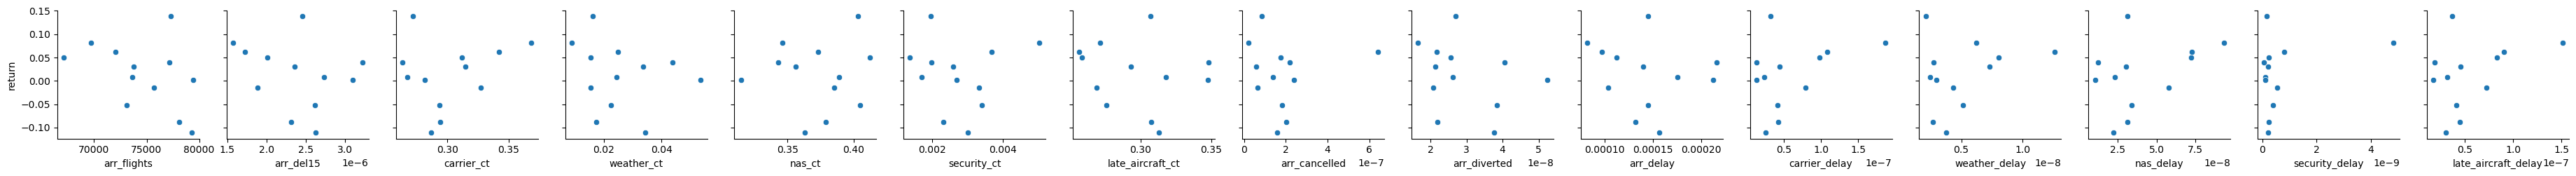

American Airlines Inc. 2021


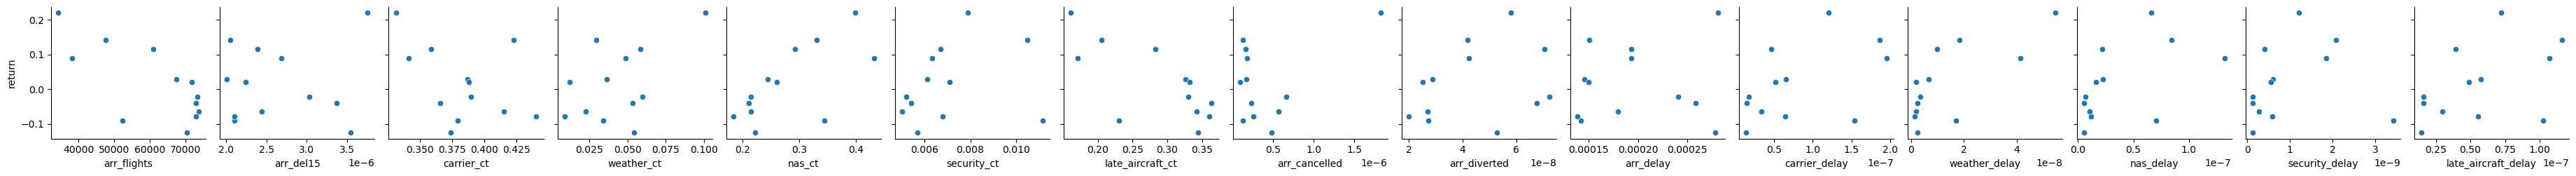

Delta Air Lines Inc. 2017


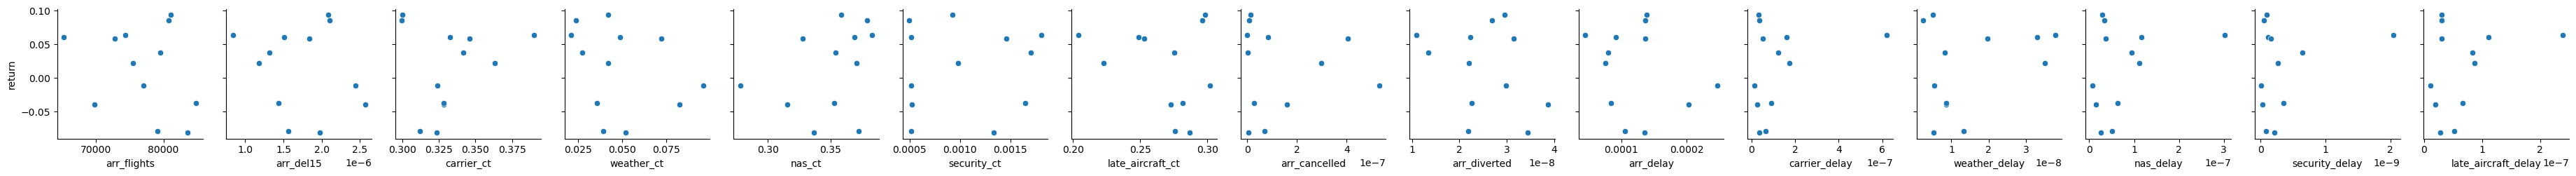

Delta Air Lines Inc. 2021


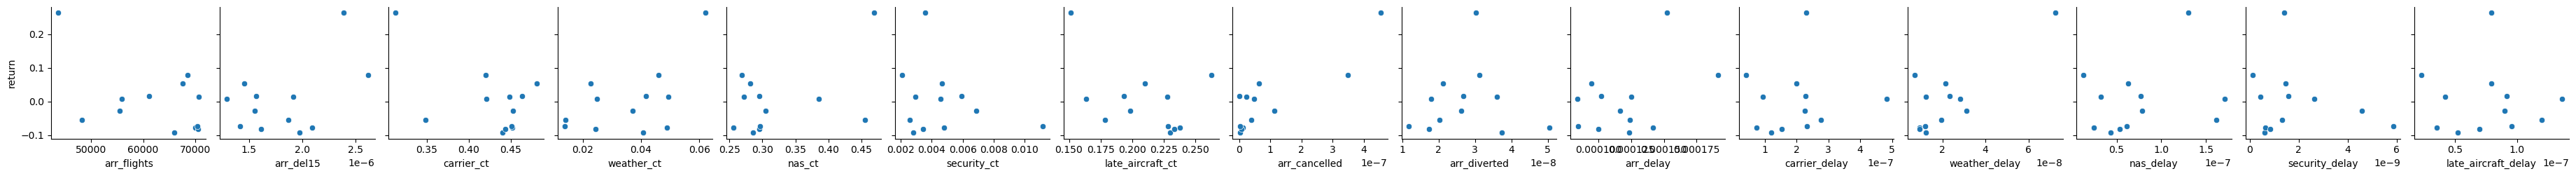

JetBlue Airways 2017


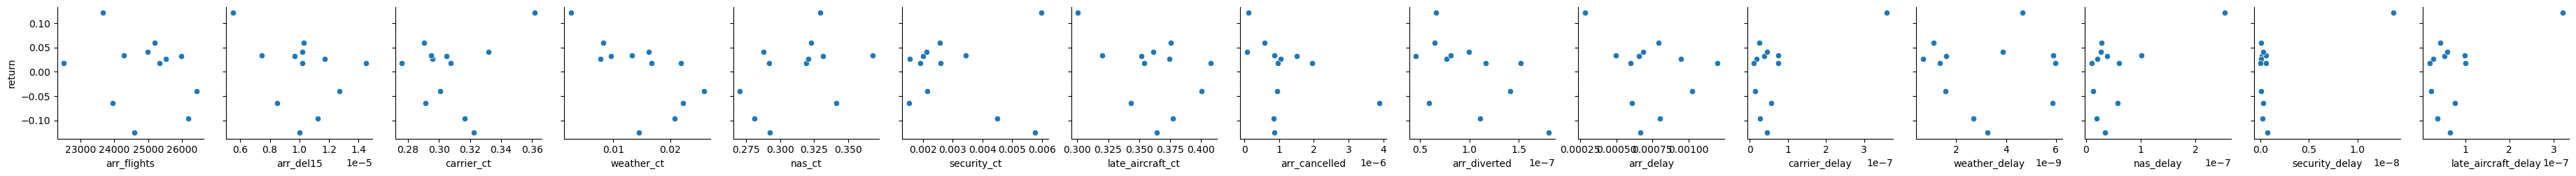

JetBlue Airways 2021


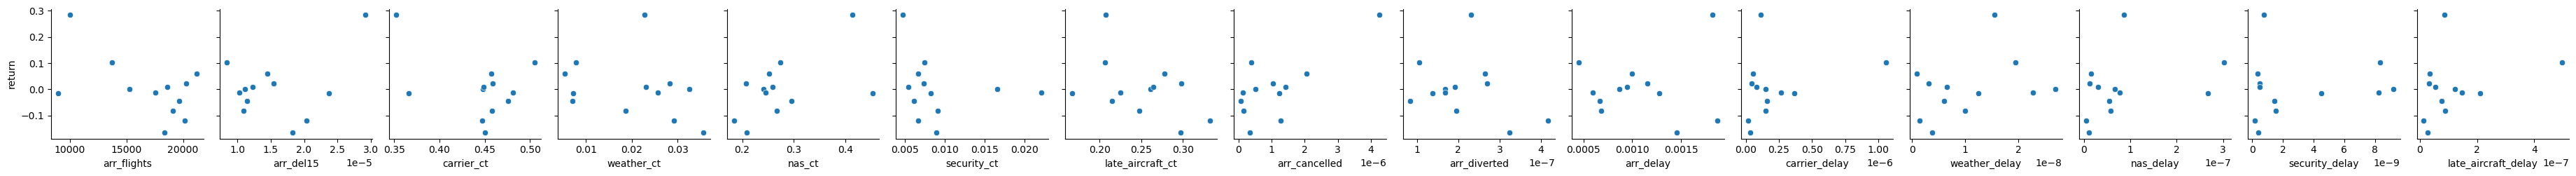

Southwest Airlines Co. 2017


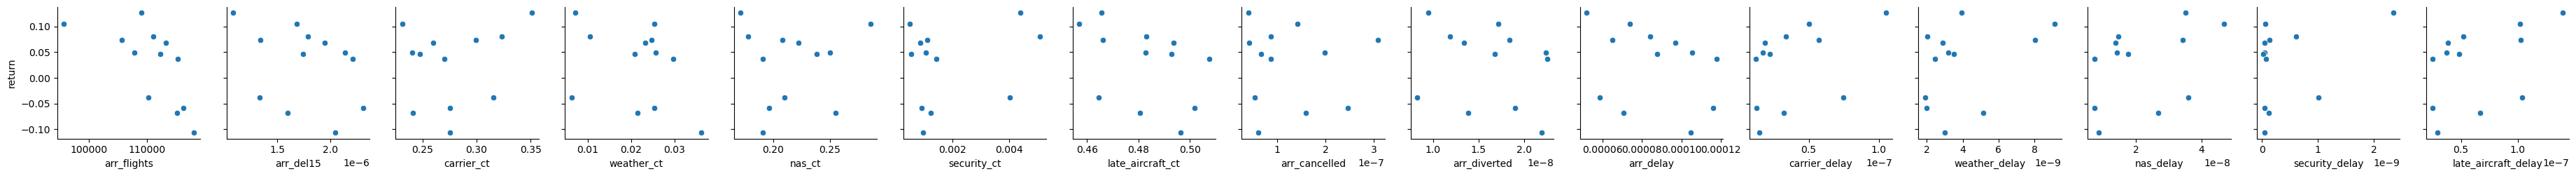

Southwest Airlines Co. 2021


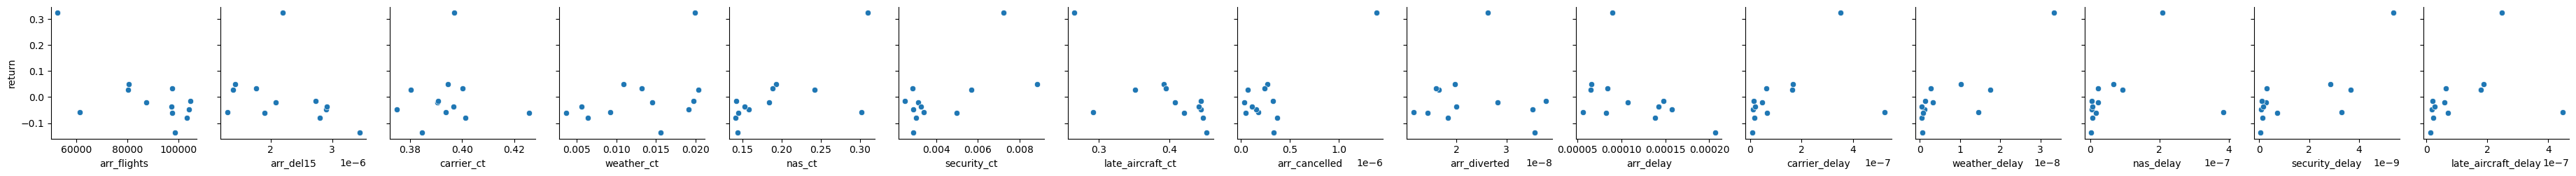

Spirit Air Lines 2017


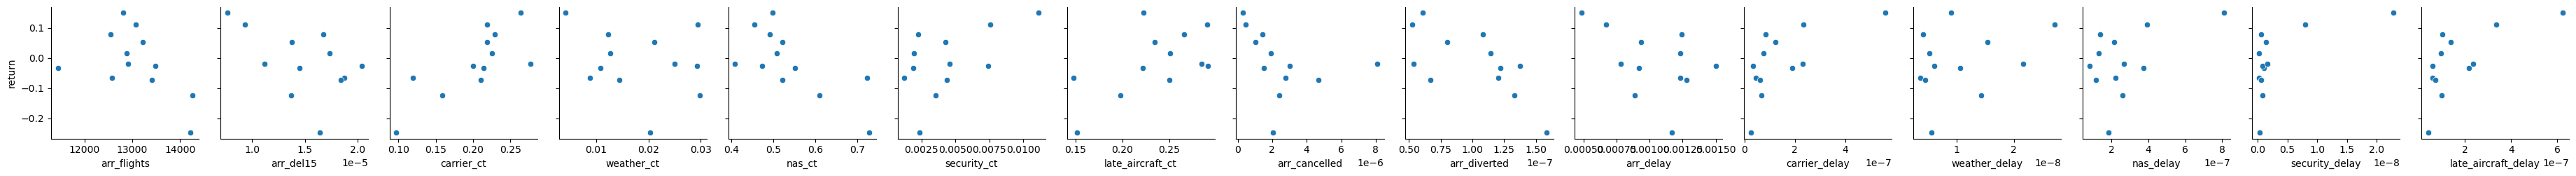

Spirit Air Lines 2021


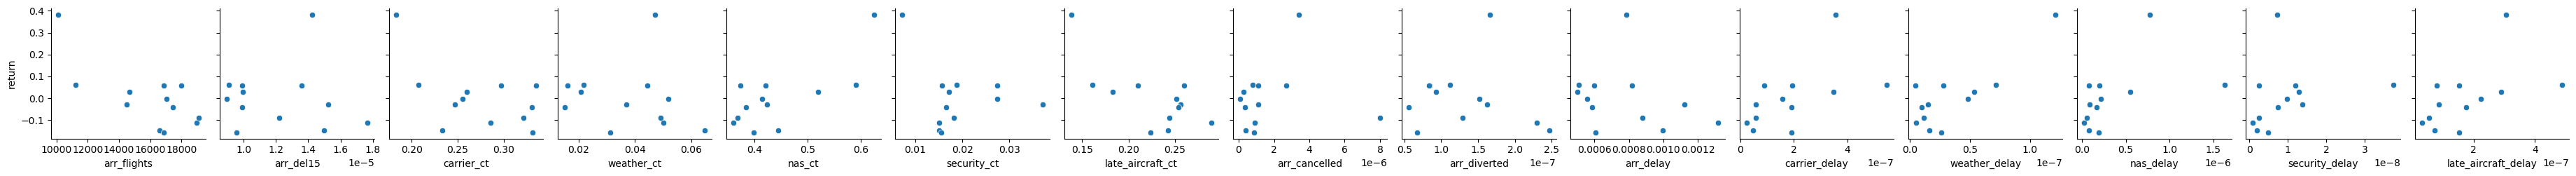

United Air Lines Inc. 2017


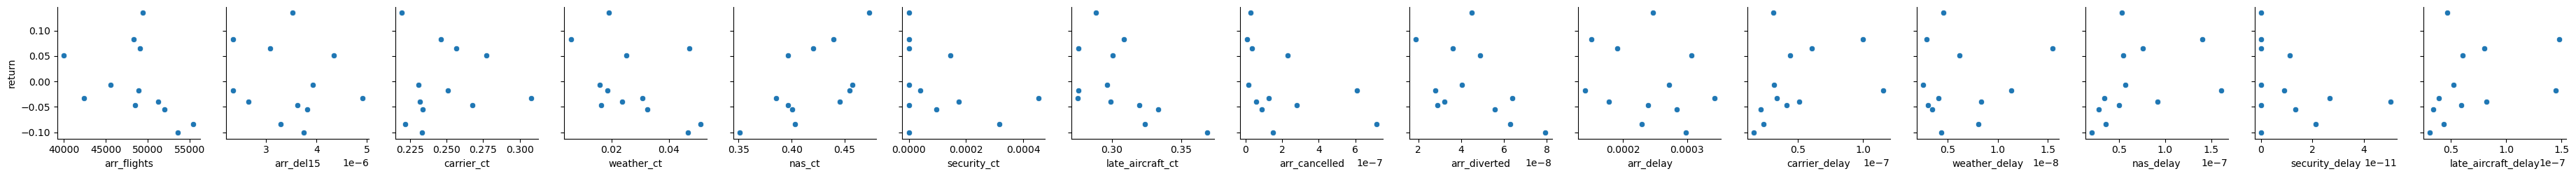

United Air Lines Inc. 2021


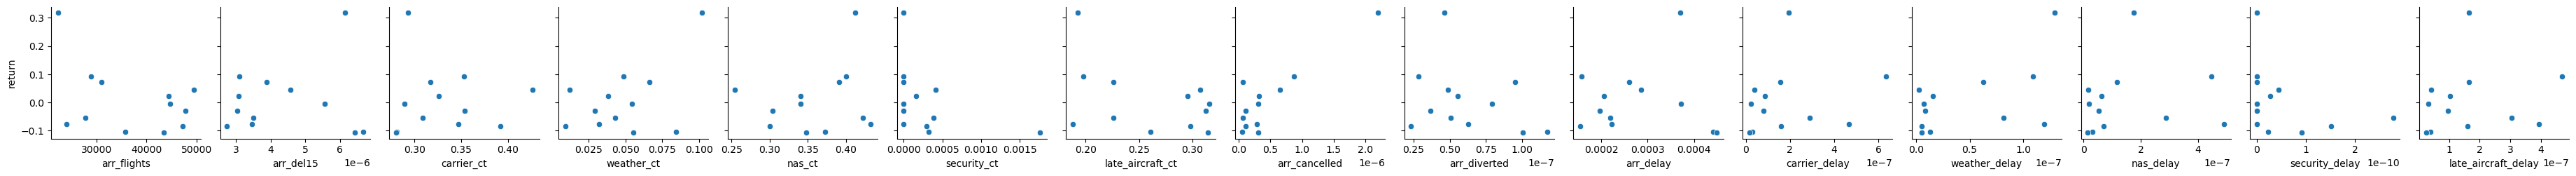

In [79]:
for carrier_name in unique_carrier_names:
    pp = sns.pairplot(data=norm17[norm17['carrier_name'] == carrier_name],
                      y_vars=['return'],
                      x_vars=['arr_flights', 'arr_del15', 'carrier_ct', 'weather_ct', 'nas_ct', 
                              'security_ct', 'late_aircraft_ct', 'arr_cancelled', 'arr_diverted', 
                              'arr_delay', 'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 
                              'late_aircraft_delay'])
    # save the figure
    plt.savefig(
        f'../output/reports/figures/flight_delay_stock_pairplot_{carrier_name}_2017.png', dpi=300)
    # print the carrier name
    print(carrier_name, '2017')
    plt.show()

    pp = sns.pairplot(data=norm21[norm21['carrier_name'] == carrier_name],
                      y_vars=['return'],
                      x_vars=['arr_flights', 'arr_del15', 'carrier_ct', 'weather_ct', 'nas_ct', 'security_ct', 
                              'late_aircraft_ct', 'arr_cancelled', 'arr_diverted', 'arr_delay', 'carrier_delay', 
                              'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay'])
    # save the figure
    plt.savefig(
        f'../output/reports/figures/flight_delay_stock_pairplot_{carrier_name}_2021.png', dpi=300)
    # print the carrier name
    print(carrier_name, '2021')
    plt.show()


The pairplots for each airline correspond to the correlation table above. arr_flights seems to be negatively correlated with monthly returns for almost every airline. Additionally the sign flipped for the correlation between 'month' and 'return' between 2017 and 2021. Additionally there seems to be a lot of change in correlation for carrier_ct and return between 2017 and 2021.

### Linear Regression on the Delay and Stock Return Data

We have 12 observations for each airline in 2017 and 2021, so we will use only one independent variable in our feature selection for each airline for each year. Additionally, since we have such a small selection of points, we will use crossvalidation to find the average mean squared error for our models for each airline. We found in the previous analysis that the carrier related delay count was a statistically significant difference between 2017 and 2021, so we will use that as our independent variable for each airline, and then the target will be monthly stock returns for each airline.

American Airlines Inc. - Average Root Mean Squared Error: 0.06236894171250032
Delta Air Lines Inc. - Average Root Mean Squared Error: 0.06271014429129762
JetBlue Airways - Average Root Mean Squared Error: 0.07281782445708566
Southwest Airlines Co. - Average Root Mean Squared Error: 0.07658904340095439
Spirit Air Lines - Average Root Mean Squared Error: 0.07297435349634654
United Air Lines Inc. - Average Root Mean Squared Error: 0.07093577414545015


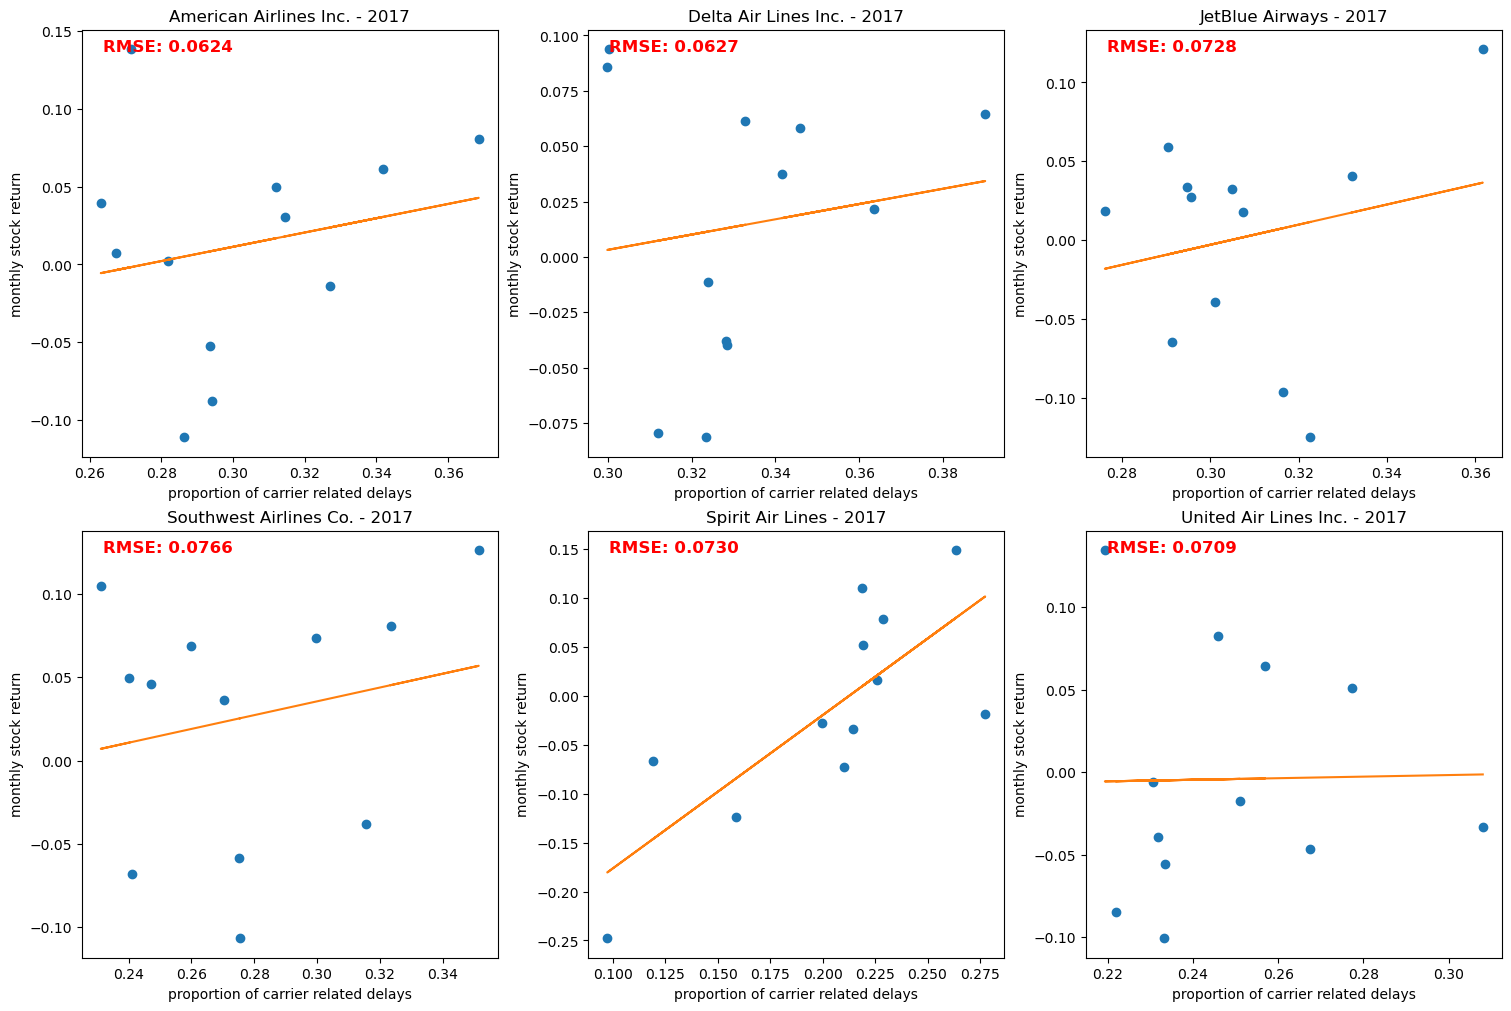

In [80]:
# with normalized values
plot_airline_regression(norm17, 2017)

The best performing model was Delta Air Lines Inc, with an RMSE of 0.0627. This means that the model's predicted values were on average .0627 away from the actual monthly stock return for the associated carrier-related delay value. Given that Delta Airline's monthly stock return ranged from -.075 to .1, this is not a good model.

American Airlines Inc. - Average Root Mean Squared Error: 0.08534359492513373
Delta Air Lines Inc. - Average Root Mean Squared Error: 0.09415793282647851
JetBlue Airways - Average Root Mean Squared Error: 0.10817285299598121
Southwest Airlines Co. - Average Root Mean Squared Error: 0.09315465936526297
Spirit Air Lines - Average Root Mean Squared Error: 0.11437108859436233
United Air Lines Inc. - Average Root Mean Squared Error: 0.1042795490223596


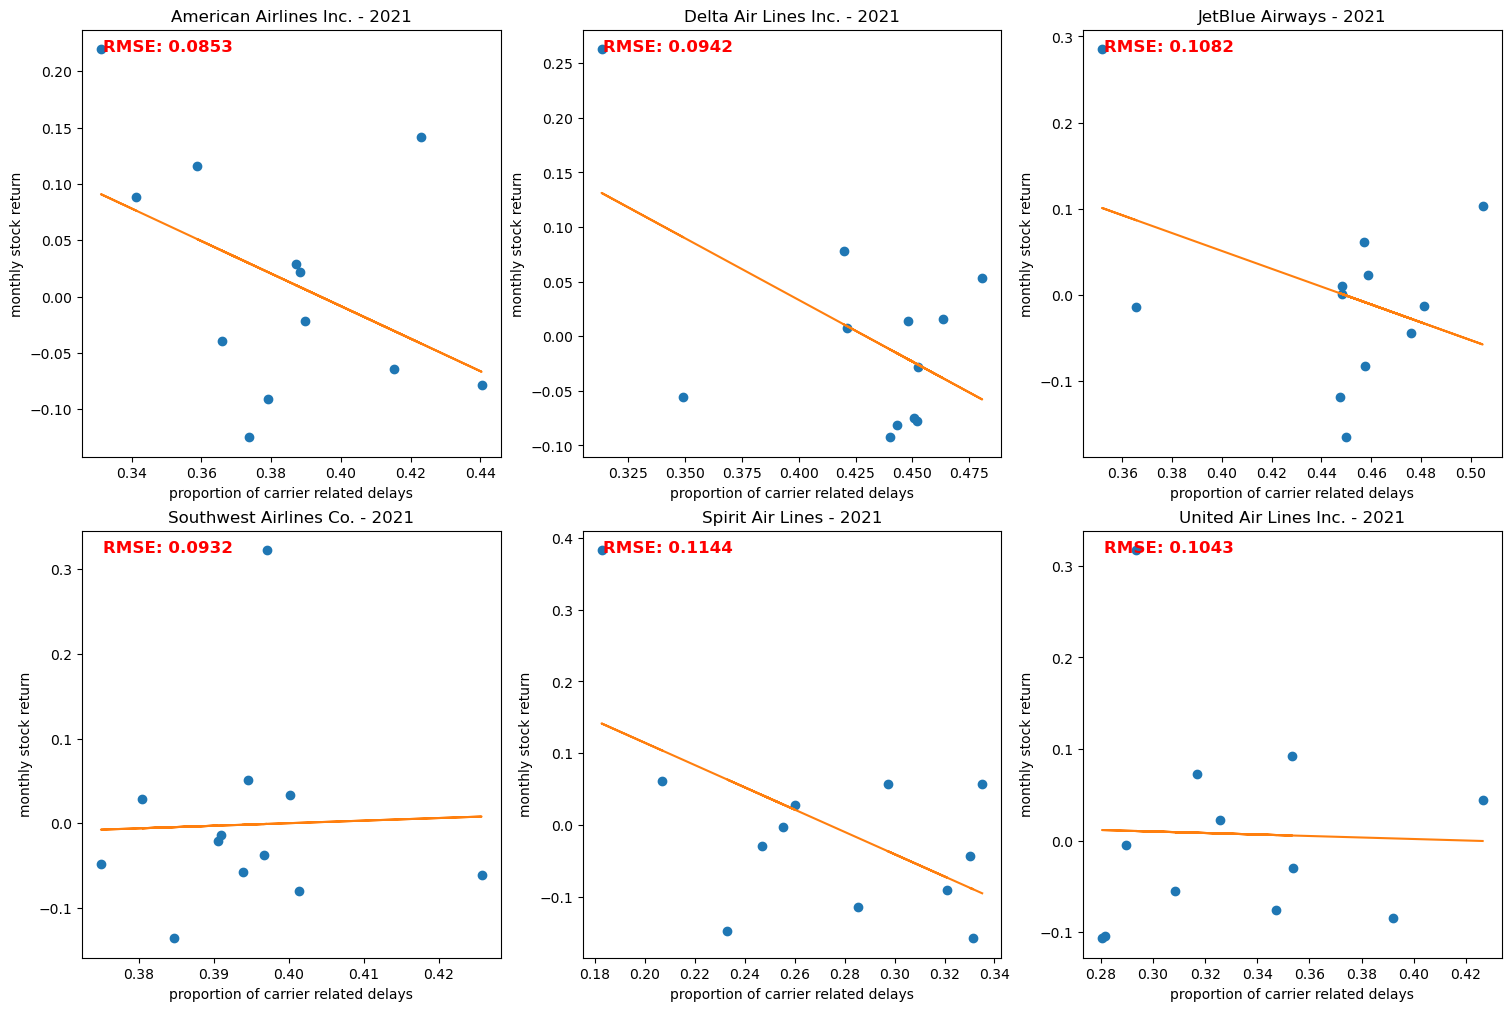

In [81]:
plot_airline_regression(norm21, 2021)

The RMSE values look worse for 2021, but there was more variability in the stock returns for each airline in 2021 than in 2017, so they are not directly comparable. The best performing model was American Airlines Inc for 2021, with a RMSE of 0.0853. The stock return values ranged from about -.1 to .2, and on average the model's predicted values were .0853 away from the actual monthly stock return for the associated carrier-related delay value. This is also not a good model.